# Predicting Gentrification
*A study into planning application features that can help to signal early warnings of gentrification*
</br></br></br></br>
`Notebook 1: Cleaning and EDA of Permits Dataset`</br>
Author: Mariia Shapovalova</br>
Date: April, 2023

---
## Table of Contents
Notebook 1: Planning Application Dataset Cleaning and EDA
- [0.0 Introduction](#identifier_0)
- [1.0 High Level Overview](#identifier_1)
  - Developing Understanding of the dataset
- [2.0 Initial Feature Selection](#identifier_2)
  - [Inital Feature Selection](#identifier_2.1)
    - Removing features that have more than 15% null 
- [3.0 Census_Tract_Cleaning](#identifier_3)
  - Inferring Census Tracts using censusgecoder
  - Further replacing Census Tracts based on the changes made in the income dataset
- [4.0 Overall Cleaning](#identifier_4)
  - Further Feature Selection
  - Filling in null values
- [5.0 EDA](#heading_identifier_5)
  - [Numeric Columns](#identifier_5.1)
    - Further Feature selection
    - Applying Log Transformation to normalize numeric distributions
  - [Categorical Columns](#identifier_5.2)
    - Permit Type
    - Review Type
    - Contact_1_Type, City and State
- [6.0 Export Cleaned Dataset](#identifier_6)

---
<center><h2 id="identifier_0">INTRODUCTION</h2><center>

### Introduction to The Project


**Research Aim:**

Gentrification refers to a demographic transformation of a neighbourhood in which lower-income groups are displaced by the influx of residents from a higher social class. Gentrification has been studied extensively in recent years due to its increasing occurrence in major cities, with notable examples of Hackney in London or Wicker Park in Chicago. However, while gentrification can contribute to local economic development and revitalisation, it often results in the displacement of long-term residents, cultural erosion, and rising living costs, making it a highly contested and complex issue. 

Due to its increasing occurrence in major cities, gentrification has been studied extensively in the quest to achieve inclusive and sustainable urban development. However, in most cases, gentrification is evaluated after it occurs. To address this issue, researchers have been developing methodologies that predict gentrification before it happens. To contribute to this discourse, this project creates a machine-learning workflow to analyse building permits in Chicago. By predicting gentrification and understanding the factors that contribute to it, policymakers and communities can take proactive measures to mitigate its negative impacts and promote equitable and inclusive urban development. 


**Datasets:**

This project will be exploring 2 type of datasets: Chicago Planning Application Dataset (2006 to present, updated daily) and US Census Income Datasets (one for each year from 2010 to 2021).  



### Introduction to this Notebook 


The purpose of this notebook is to understand, clean and conduct initial EDA of Chicago Planning Application Dataset. </br>
The dataset was downloaded from Chicago Data Portal, which can be accessed using the following link [Planning Applications Link](https://data.cityofchicago.org/Buildings/Building-Permits/ydr8-5enu).

---
<center><h2 id="identifier_1">HIGH LEVEL OVERVIEW</h2><center>

* Define functions useful for high level overview

In [6]:
#import relevant packages
import numpy as np
import pandas as pd

import joblib
import re

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#requires pip install censusgeocode
import censusgeocode as cg

from functions import *

### 1.1 Importing Data

In [7]:
#load data
permits_raw=pd.read_csv('../src/data/Building_Permits.csv')

* Check that data was imported correctly

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
#preview top 5 rows
permits_raw.head()

,ID,PERMIT#,PERMIT_TYPE,REVIEW_TYPE,APPLICATION_START_DATE,ISSUE_DATE,PROCESSING_TIME,STREET_NUMBER,STREET DIRECTION,STREET_NAME,SUFFIX,WORK_DESCRIPTION,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,SUBTOTAL_PAID,BUILDING_FEE_UNPAID,ZONING_FEE_UNPAID,OTHER_FEE_UNPAID,SUBTOTAL_UNPAID,BUILDING_FEE_WAIVED,ZONING_FEE_WAIVED,OTHER_FEE_WAIVED,SUBTOTAL_WAIVED,TOTAL_FEE,CONTACT_1_TYPE,CONTACT_1_NAME,CONTACT_1_CITY,CONTACT_1_STATE,CONTACT_1_ZIPCODE,CONTACT_2_TYPE,CONTACT_2_NAME,CONTACT_2_CITY,CONTACT_2_STATE,CONTACT_2_ZIPCODE,CONTACT_3_TYPE,CONTACT_3_NAME,CONTACT_3_CITY,CONTACT_3_STATE,CONTACT_3_ZIPCODE,CONTACT_4_TYPE,CONTACT_4_NAME,CONTACT_4_CITY,CONTACT_4_STATE,CONTACT_4_ZIPCODE,CONTACT_5_TYPE,CONTACT_5_NAME,CONTACT_5_CITY,CONTACT_5_STATE,CONTACT_5_ZIPCODE,CONTACT_6_TYPE,CONTACT_6_NAME,CONTACT_6_CITY,CONTACT_6_STATE,CONTACT_6_ZIPCODE,CONTACT_7_TYPE,CONTACT_7_NAME,CONTACT_7_CITY,CONTACT_7_STATE,CONTACT_7_ZIPCODE,CONTACT_8_TYPE,CONTACT_8_NAME,CONTACT_8_CITY,CONTACT_8_STATE,CONTACT_8_ZIPCODE,CONTACT_9_TYPE,CONTACT_9_NAME,CONTACT_9_CITY,CONTACT_9_STATE,CONTACT_9_ZIPCODE,CONTACT_10_TYPE,CONTACT_10_NAME,CONTACT_10_CITY,CONTACT_10_STATE,CONTACT_10_ZIPCODE,CONTACT_11_TYPE,CONTACT_11_NAME,CONTACT_11_CITY,CONTACT_11_STATE,CONTACT_11_ZIPCODE,CONTACT_12_TYPE,CONTACT_12_NAME,CONTACT_12_CITY,CONTACT_12_STATE,CONTACT_12_ZIPCODE,CONTACT_13_TYPE,CONTACT_13_NAME,CONTACT_13_CITY,CONTACT_13_STATE,CONTACT_13_ZIPCODE,CONTACT_14_TYPE,CONTACT_14_NAME,CONTACT_14_CITY,CONTACT_14_STATE,CONTACT_14_ZIPCODE,CONTACT_15_TYPE,CONTACT_15_NAME,CONTACT_15_CITY,CONTACT_15_STATE,CONTACT_15_ZIPCODE,REPORTED_COST,PIN1,PIN2,PIN3,PIN4,PIN5,PIN6,PIN7,PIN8,PIN9,PIN10,COMMUNITY_AREA,CENSUS_TRACT,WARD,XCOORDINATE,YCOORDINATE,LATITUDE,LONGITUDE,LOCATION
0,1614287,100072880,PERMIT - RENOVATION/ALTERATION,STANDARD PLAN REVIEW,10/14/2005,01/03/2006,81.0,2728,N,MONTICELLO,AVE,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,125.0,75.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,OWNER AS GENERAL CONTRACTOR,MARIA AND GABRIEL BAILON,CHICAGO,IL,60647,ARCHITECT,IURO ANTHONY J,CHICAGO,IL,60602-,CONTRACTOR-ELECTRICAL,J K & S ELECTRICAL CO.,SOUTH HOLLAND,IL,60473-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,13-26-305-033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.151539e+06,1.918031e+06,41.930957,-87.718543,POINT (-87.718542820893 41.930957454144)
1,1614342,100072909,PERMIT - NEW CONSTRUCTION,STANDARD PLAN REVIEW,12/05/2005,03/29/2006,114.0,1409,S,KEDVALE,AVE,"new construction, erect 3 story slab on grade ...",1029.6,112.5,100.0,1242.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1242.1,ARCHITECT,LISEC MICHAEL,CHICAGO X,IL,60607,BUILDING OWNER,MARVIN HUNTER,CHICAGO,IL,60623,CONTRACTOR-ELECTRICAL,HERNANDEZ ELECTRIC,CHICAGO,IL,60623-,CONTRACTOR-GENERAL CONTRACTOR,"PRECISE INDUSTRIAL SERVICES, I",CHICAGO,IL,60637-,MASON - BRICK AND CONCRETE,LARNIKKS CONTRACTING,CHICAGO,IL,60659-,MASON - BRICK ONLY,"TITAN MASONRY ENTERPRISES, INC",PEOTONE,IL,60468-,CONTRACTOR-PLUMBER/PLUMBING,"PL14612-PLUMBERS, INC.",OAK PARK,IL,60304-,CONTRACTOR-VENTILATION,J & A HEATING A/C,CHGO,IL,60660,OWNER,NEW JERUSALEM CHRISTIAN DEVELOPMENT CORP.,CHICAGO,IL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190000.0,16-22-220-004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.148986e+06,1.892939e+06,41.862155,-87.728575,POINT (-87.728575200899 41.862154886848)
2,1614371,100072936,PERMIT - SIGNS,SIGN PERMIT,10/17/2005,01/12/2006,87.0,120,S,LA SALLE,ST,north elevation 386431,56.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,CONTRACTOR-ELECTRICAL,ICON IDENTITY SOLUTIONS,ROLLING MEADOWS,IL,60008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

***What is the shape of the dataset and what columns are included?***

In [10]:
#apply a custom function 'overview' to create a dataframe 'raw_overview' that provides a high level summary of each column
raw_overview=overview(permits_raw)

The dataframe shape is (730511, 119)


* The raw planning application dataset contains `730511` rows and `119` columns. The next subsection 1.2 will aim to establish which features out of the 119 can be useful for the project

The dataset contains too many columns to be previewed at once
* Preview the first 10 columns


In [11]:
raw_overview[:10]

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
ID,int64,0,0.000000,1614287,3308675,3024177
PERMIT#,object,0,0.000000,100072880,101006675,100812531
PERMIT_TYPE,object,0,0.000000,PERMIT - RENOVATION/ALTERATION,PERMIT - ELECTRIC WIRING,PERMIT - ELECTRIC WIRING
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,04/03/2019
ISSUE_DATE,object,0,0.000000,01/03/2006,02/24/2023,04/04/2019
PROCESSING_TIME,float64,522,0.071457,81.0,0.0,1.0
STREET_NUMBER,int64,0,0.000000,2728,12423,9255
STREET DIRECTION,object,0,0.000000,N,S,S


* Preview the last 10 columns

In [12]:
raw_overview[-10:]

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PIN9,object,726951,99.512670,NaN,NaN,NaN
PIN10,object,727438,99.579336,NaN,NaN,NaN
COMMUNITY_AREA,float64,104841,14.351735,NaN,53.0,48.0
CENSUS_TRACT,float64,109049,14.927770,NaN,530503.0,480500.0
WARD,float64,105051,14.380482,NaN,34.0,7.0
XCOORDINATE,float64,1352,0.185076,1151538.764988,1174277.877745,1194829.117987
YCOORDINATE,float64,1352,0.185076,1918030.52352,1822395.541195,1843868.62618
LATITUDE,float64,2254,0.308551,41.930957,41.668048,41.726492
LONGITUDE,float64,2254,0.308551,-87.718543,-87.637825,-87.561909


***What is the timeframe of the planning application included in the dataset?***

In [13]:
#The timeframe can be determined using APPLICATION_START_DATE & ISSUE_DATE columns
fisrt_start_date=min(permits_raw['APPLICATION_START_DATE'].astype('datetime64'))
fisrt_issue_date=min(permits_raw['ISSUE_DATE'].astype('datetime64'))
last_start_date=max(permits_raw['APPLICATION_START_DATE'].astype('datetime64'))
last_issue_date=max(permits_raw['ISSUE_DATE'].astype('datetime64'))

In [14]:
print(f'The timeframe of applicatation START dates are between {fisrt_start_date} and {last_start_date}')
print(f'The timeframe of applicatation ISSUE dates are between {fisrt_issue_date} and {last_issue_date}')

The timeframe of applicatation START dates are between 2001-07-25 00:00:00 and 2023-02-24 00:00:00
The timeframe of applicatation ISSUE dates are between 2006-01-03 00:00:00 and 2023-02-24 00:00:00


* The dataset was downloaded on the 16th of February 2023, which explained why the last START and ISSUE dates are 2023-02-24
* According to Chicago Data Portal, the dataset is being updated daily

</br>

## Understanding Data
To evaluate the usability/quality of the data, let's first look at the number of nulls in each column

* Preview 10 columns with the least null values

In [15]:
#preview top 10 columns with the least null values
raw_overview.sort_values('Total Null Values').head(10)

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
ID,int64,0,0.0,1614287,3308675,3024177
TOTAL_FEE,float64,0,0.0,200.0,75.0,75.0
SUBTOTAL_WAIVED,float64,0,0.0,0.0,0.0,0.0
OTHER_FEE_WAIVED,float64,0,0.0,0.0,0.0,0.0
ZONING_FEE_WAIVED,float64,0,0.0,0.0,0.0,0.0
BUILDING_FEE_WAIVED,float64,0,0.0,0.0,0.0,0.0
SUBTOTAL_UNPAID,float64,0,0.0,0.0,0.0,0.0
OTHER_FEE_UNPAID,float64,0,0.0,0.0,0.0,0.0
ZONING_FEE_UNPAID,float64,0,0.0,0.0,0.0,0.0


* Preview 10 columns with the most null values

In [16]:
#preview top 10 columns with the most null values
raw_overview.sort_values('Total Null Values',ascending=False).head(10)

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
CONTACT_15_ZIPCODE,float64,730506,99.999316,NaN,NaN,NaN
CONTACT_15_TYPE,object,730506,99.999316,NaN,NaN,NaN
CONTACT_15_NAME,object,730506,99.999316,NaN,NaN,NaN
CONTACT_15_CITY,object,730506,99.999316,NaN,NaN,NaN
CONTACT_15_STATE,object,730506,99.999316,NaN,NaN,NaN
CONTACT_14_TYPE,object,730483,99.996167,NaN,NaN,NaN
CONTACT_14_NAME,object,730483,99.996167,NaN,NaN,NaN
CONTACT_14_CITY,object,730483,99.996167,NaN,NaN,NaN
CONTACT_14_ZIPCODE,object,730483,99.996167,NaN,NaN,NaN


* While there are 119 columns (potential features) in the dataset - some columns contain almost exclusively null values 

**What is inside the data?**

To better understand different types of columns in the dataset select columns cointaining different words such as 'FEE', 'TYPE', 'CONTACT'

In [17]:
#Using a custom function defined in functions.py select columns containing 'FEE' in its name 
get_columns_with_regex(permits_raw,'FEE').sample()

,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,BUILDING_FEE_UNPAID,ZONING_FEE_UNPAID,OTHER_FEE_UNPAID,BUILDING_FEE_WAIVED,ZONING_FEE_WAIVED,OTHER_FEE_WAIVED,TOTAL_FEE
638891,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


* Each row has data for different type of Fees Paid for each application
* Fees paid depend on the type of application and, hence, contain information about the type of application. 

In [18]:
#Select columns containing 'TYPE' in their names
get_columns_with_regex(permits_raw,'TYPE').sample()

,PERMIT_TYPE,REVIEW_TYPE,CONTACT_1_TYPE,CONTACT_2_TYPE,CONTACT_3_TYPE,CONTACT_4_TYPE,CONTACT_5_TYPE,CONTACT_6_TYPE,CONTACT_7_TYPE,CONTACT_8_TYPE,CONTACT_9_TYPE,CONTACT_10_TYPE,CONTACT_11_TYPE,CONTACT_12_TYPE,CONTACT_13_TYPE,CONTACT_14_TYPE,CONTACT_15_TYPE
350929,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,CONTRACTOR-ELECTRICAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Different Permit, Review and Contact Types
* Each Application contains information about up to 15 contacts responsible for the project

In [19]:
#Select columns containing 'CONTACT_1' in their names to understand what type of information is provided for each contact
get_columns_with_regex(permits_raw,'CONTACT_1_').sample()

,CONTACT_1_TYPE,CONTACT_1_NAME,CONTACT_1_CITY,CONTACT_1_STATE,CONTACT_1_ZIPCODE
36788,CONTRACTOR-GENERAL CONTRACTOR,MARK I RESTORATION COMPANY,DOLTON,IL,60419-


* Each Contact contains its Type (such as Architect, Contractor, Owner), Name and Contact's Local Address (City, State and Zipcode)

---
<center><h2 id="identifier_2">Initial Feature Selection</h2></center>

### Null Values and Inital Feature Selection

Let's drop columns where the number of nulls is 15% or more

In [20]:
raw_overview[raw_overview['Null Values Percentage']>=15]

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
CONTACT_2_TYPE,object,277310,37.961098,ARCHITECT,NaN,NaN
CONTACT_2_NAME,object,277310,37.961098,IURO ANTHONY J,NaN,NaN
CONTACT_2_CITY,object,278918,38.181218,CHICAGO,NaN,NaN
CONTACT_2_STATE,object,279326,38.237070,IL,NaN,NaN
CONTACT_2_ZIPCODE,object,290681,39.791461,60602-,NaN,NaN
...,...,...,...,...,...,...
PIN6,object,722630,98.921166,NaN,NaN,NaN
PIN7,object,725029,99.249566,NaN,NaN,NaN
PIN8,object,726086,99.394260,NaN,NaN,NaN


In [21]:
#Calculate the percentage of null rows for each column
col_non_valid=raw_overview[raw_overview['Null Values Percentage']>=15].index

#Valid columns (where the number of nulls is less than 15%)
col_valid=[col for col in permits_raw.columns if col not in col_non_valid]

In [22]:
#Drop non-valid columns
permits_wip_1=permits_raw.drop(columns=col_non_valid)

In [23]:
overview(permits_wip_1)

The dataframe shape is (730511, 40)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
ID,int64,0,0.000000,1614287,3308675,2978162
PERMIT#,object,0,0.000000,100072880,101006675,100784539
PERMIT_TYPE,object,0,0.000000,PERMIT - RENOVATION/ALTERATION,PERMIT - ELECTRIC WIRING,PERMIT - ELECTRIC WIRING
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,09/22/2018
ISSUE_DATE,object,0,0.000000,01/03/2006,02/24/2023,09/22/2018
PROCESSING_TIME,float64,522,0.071457,81.0,0.0,0.0
STREET_NUMBER,int64,0,0.000000,2728,12423,8123
STREET DIRECTION,object,0,0.000000,N,S,W


Drop  Remaining Columns not relevant for the project

In [24]:
col_drop=['PERMIT#','WARD','COMMUNITY_AREA','PIN1','CONTACT_1_NAME','CONTACT_1_ZIPCODE','XCOORDINATE','YCOORDINATE']
permits_wip_2=permits_wip_1.drop(columns=col_drop)

### Duplicates 

In [25]:
print(f"There are {permits_wip_2.duplicated().sum()} duplicate rows")

There are 0 duplicate rows


Currently no duplicates but this would need to be checked again as we refine the columns being used.

***

**<center><h2> CENSUS TRACTS CLEANING <center><h2>**

## Introduction to Census Tract Cleaning

* Census Tract Codes are key to the project as they form the link between different datasets.
* However, currently, almost 15% of datapoints are missing a census tract number
* Moreover, currently provided census tracts are not all in the correct format and there might be differences in the census tract notation between the years

In [26]:
(f"Currently {permits_wip_2['CENSUS_TRACT'].isna().sum()*100/permits_wip_2.shape[0]:.2f}% of datapoints have census tracts missing")

'Currently 14.93% of datapoints have census tracts missing'

* Let's check if there are any patterns between the data of permit and its corresponding missing census_tracts

In [27]:
permits_census_nulls=permits_wip_2[permits_wip_2['CENSUS_TRACT'].isna()]
round(permits_census_nulls.groupby(permits_census_nulls['ISSUE_DATE'].astype('datetime64').dt.year).size()*100/permits_census_nulls.shape[0],2)

ISSUE_DATE
2006    42.95
2007    43.82
2008     6.04
2009     0.26
2010     0.30
2011     0.29
2012     0.24
2013     0.33
2014     0.32
2015     0.31
2016     0.35
2017     0.32
2018     0.43
2019     0.45
2020     0.53
2021     1.40
2022     1.42
2023     0.22
dtype: float64

* Most nulls in the CENSUS_TRACT column are coming from the data in 2006 & 2007. Dropping the null rows would, hence, result in losing almost half of the data for 2006 & 2007

</br>

## Infer Census Tracts using `censusgeocode`

* Aim of this subsection is to create a dictionary `{each ID: correct census tract number}`

***Census Tract Code Notation***
* Census Tracts encompass small geographical subdivisions of a county used for statistical research
* Generally, census tracts have between 2,500 and 8,000 residents. However, as a part of this reseach it was discovered that many census tracts in Chicago contained less than 600 residents.
* Full Census Tract Code (inside one County) should contain 6 digits in total :
  *  4-digit base code (randing from 0 to 9999) 
  *  2-digit suffix (00,01,02 etc) added when the base geography is being split futher
* Census Tract Codes were updated between 2019 and 2020, with some geographies having suffixes 00 split into 01 and 02 and others having 01, 02 suffixes merged into 00
* This happens when
* Further documentation about census tract notation can be downloaded [here](https://www2.census.gov/geo/pdfs/reference/GARM/Ch10GARM.pdf)
</br>
</br>
**Previous Approach**
* Initially it was attempted to reformat existing cenusus tract number using the following logic:
  * Convert all codes to strings, to ensure leading zeros are not misisng
  * Add 0s at the beginning of codes until all codes have at least 4 digits (assuming that zeros were previously lost due to conversion to numbers. eg. 101 and 0101)
  * For codes that had less than 6 digits, add 0s to the end, assuming that the suffix of 00 was dropped
* This approach allowed to match most census tracts to the other datasets, but some were still miss-matching. Likely due to the fact that notation would change between the years
* Overall, this approach wasn't very robust as it relied on a number of assumptions for formatting. Additionally, it was only allowing to use datapoint where census tracts were already present
</br>
</br>
**Current Approach**
* ***censusgeocode*** can be used to infer census tracts based on 
  * a) coordinates (longitude and latitude)
  * b) address (street name, street number, city, state, zipcode)
* While there are addresses for all rows, it would take a very long time to run the geocoder on the whole dataset (more than 100 hours)
  * Additionally, method since out dataset does not have zipcodes, running the geocoder on addresses doesn't gurantee that matches will be found
* To reduce the runtime datapoints from same census tracts can be grouped together
  * geocoder will run on the groups and then its output mapped onto the whole dataframe using dictionaries 

In [28]:
#check missing values for the columns that can be helpful to infer misisng census tract numbers
permits_wip_2[['ID','CENSUS_TRACT','STREET_NAME', 'STREET DIRECTION','STREET_NUMBER','SUFFIX','LATITUDE','LONGITUDE']].isna().sum()

ID                       0
CENSUS_TRACT        109049
STREET_NAME              0
STREET DIRECTION         0
STREET_NUMBER            0
SUFFIX                6762
LATITUDE              2254
LONGITUDE             2254
dtype: int64

Proposed Data Groupings to reduce the geocoder runtime:
* Group 1: existing census tracts with known coordinates
  * **groupby:** existing census tracts
  * **infer using:** coordinates
  * [Note]: transfer existing census tracts that do not have coordinates defined anywhere in the dataset to group 3, will be defined as `missing_li`
* Group 2: NO existing census tract BUT coordinates present
  * **groupby:** rounded coordinates
  * **infer using:** coordinates
* Group 3: NO existing census tract and NO coordinates present + missing_li
  * **groupby:** addresses
  * **infer using:** addresses

</br>

### A) Datapoints with census tracts present
* **Groupby**: existing Census Tract
* **Geocoder Input**: coordinates (Latitude & Longitude)

In [29]:
#it was noticed that some census tracts were recorded as 0, which does not exist. replace 0 values to be nan
permits_wip_2['CENSUS_TRACT']=permits_wip_2['CENSUS_TRACT'].replace({0.0:np.nan})

#Create a mask to filter rows that DO NOT contain null values for the Census Tract
tract_present_mask=~permits_wip_2[['CENSUS_TRACT']].isna().any(axis=1)
#create another mask to filter rows that DO NOT contain null values lat&lon coordinates
coord_present_mask=~permits_wip_2[['LATITUDE','LONGITUDE']].isna().any(axis=1)

#For this method to work both census tracts and coordinates have to be present: create according

#out of the ones that contain nulls for census_tract, do any contain nulls for latitude and longitude
permits_wip_2[tract_present_mask][['LATITUDE','LONGITUDE']].isna().sum()

LATITUDE     1688
LONGITUDE    1688
dtype: int64

* 1688 rows contain census tracts but not lat&lon coordinates
* Determine how many census tracts do not have lat&lon coordinates in any of the rows
  * if census tracts are missing lat&lon coordinates in some rows but have them in other, this method will still work
  * census tracts that do not contain lat&lon coordinates in any of the tracts should be noted and a different method to convert them into the correct format should be developed

In [30]:
#census tracts that do not cointain coordinates 
tract_no_coord=set(permits_wip_2[tract_present_mask&(~coord_present_mask)]['CENSUS_TRACT'])
#census tracts that cointain coordinates 
tract_yes_coord=set(permits_wip_2[tract_present_mask&coord_present_mask]['CENSUS_TRACT'])

#find tract that are in 'tract_no_coord' but not in 'tract_yes_coord' - in other words, census tracts with no coordinates in the whole dataset
tract_no_coord.difference(tract_yes_coord)

{8422.0, 80500.0}

* 8422.0, 80500.0 - census tracts do not have coordinates in the whole dataset
* let's make a note and place them into a list `missing_li`

In [31]:
missing_li=[i for i in tract_no_coord.difference(tract_yes_coord)]

In [32]:
#apply the masks to only have the rows with ct and coordiantes present
masks_combined=(tract_present_mask&coord_present_mask)
df_temp=permits_wip_2[masks_combined]

#GROUPBY census tract to reduce the runtime of the geocoder
census_tracts_coord=df_temp.groupby('CENSUS_TRACT')[['LATITUDE','LONGITUDE']].mean().reset_index()
census_tracts_coord

,CENSUS_TRACT,LATITUDE,LONGITUDE
0,101.0,42.020935,-87.669553
1,102.0,42.016663,-87.677855
2,103.0,42.016214,-87.666772
3,104.0,42.001777,-87.659380
4,105.0,42.004434,-87.663043
...,...,...,...
1663,843700.0,41.944811,-87.689361
1664,843800.0,41.802130,-87.643563
1665,843900.0,41.774747,-87.580143
1666,980000.0,41.979005,-87.896878


In [33]:
census_tracts_coord.isna().sum()

CENSUS_TRACT    0
LATITUDE        0
LONGITUDE       0
dtype: int64

* ***RUN THE GEOCODER***

`The code below takes 15 minutes to run`</br>

In [34]:
#cg.coordinates takes x and y arguments, where x is longitude and y is latitude
'''di_1={row['CENSUS_TRACT']:(cg.coordinates(x=row['LONGITUDE'],y=row['LATITUDE']))['Census Tracts'][0]['TRACT'] for i,row in census_tracts_coord.iterrows()}'''
#Note: geocoder returns an nested dictionary : sequence ['Census Tracts'][0]['TRACT'] is used to access to access census tract number

"di_1={row['CENSUS_TRACT']:(cg.coordinates(x=row['LONGITUDE'],y=row['LATITUDE']))['Census Tracts'][0]['TRACT'] for i,row in census_tracts_coord.iterrows()}"

* **Note**: It took `15 minutes` to obtain census tracts for 1668 rows. Running this code on the whole dataframe (700,000 rows) would take 109 hours

In [35]:
#divide the full dataset length by the number of census tracts to calculate how long it would take to geocode all datapoints
per_row=15*60/census_tracts_coord.shape[0]
print(f'{per_row:.2f} seconds per row')
print(f'{((permits_wip_2.shape[0]/census_tracts_coord.shape[0])*15)/60:.0f} hours to run on the whole dataset - {permits_wip_2.shape[0]} rows ')

0.54 seconds per row
109 hours to run on the whole dataset - 730511 rows 


In [36]:
#Dump output
#joblib.dump(di_1,'../data/interim/di_1.pkl')

#Load back
di_1=joblib.load('../data/interim/di_1.pkl')

In [37]:
#note: now 793 unique census tracts
len(set(di_1.values()))

793

* di_1 is a dictionary that can be used to map `existing` census tract codes to `correct` census tract codes
  * keys - existing census tract codes
  * values - correct census tract codes

In [38]:
#create a dictionary where each ID (key) is matched with a correct census tract (obtained from di_1)

#this dictionary should be applied to rows that contain a census tract bumber apart from the census tracts in missing_li

#mask for census tract NOT in missing_li (missing_li - list of ct numbers that do not have coordinates)
missing_li_mask=~permits_wip_2['CENSUS_TRACT'].isin(missing_li)

df_temp_1=permits_wip_2[(tract_present_mask&missing_li_mask)]

id_to_tract_group_1={row['ID']:di_1[row['CENSUS_TRACT']] for i,row in df_temp_1.iterrows()}
#row['CENSUS_TRACT'] - existing census tract number (in the wrong format)

### 3.2 Datapoints with NO census tracts BUT coordinates present
* **Groupby**: coordinates
* **Geocoder Input**: coordinates (Latitude & Longitude)

* Determine the shape of the dataframe where rows have census tracts missing but coordiantes (lat&lon) present

In [39]:
#apply mask 1 (coordinates present) and the INVERSE of mask 2 (tract present) to obtain df where rows have census tracts missing but coordiantes (lat&lon) present
print(f'{permits_wip_2[coord_present_mask&(~tract_present_mask)].shape[0]} rows have coordinate values but no census tracts')

#create a temporary df for this section
df_temp=permits_wip_2[coord_present_mask&(~tract_present_mask)][['ID','LATITUDE','LONGITUDE']]

108529 rows have coordinate values but no census tracts


* Determine how long it would take to geoencode each pair of latitude and longitude

In [40]:
print(f'Running on the whole dataset would take {(permits_wip_2[coord_present_mask&(~tract_present_mask)].shape[0]*per_row)/3600:.2f} hours')

Running on the whole dataset would take 16.27 hours


* Let's aim to reduce the runtime by reducing the number of decimal points in latitude and longitude to combine datapoints into geographical groups

In [41]:
print(f"Currently there are {len(df_temp.groupby(['LATITUDE','LONGITUDE']).size())} unique lat&long pairs")

Currently there are 59754 unique lat&long pairs


* First, it was attempted to round lat & long to 3 decimal points, which resulted in `42758` number of unique pairs
  * This would take around 4.5 hours to run
  * There are only around 866 census tracts in Chicago [ref link](https://guides.lib.uchicago.edu/c.php?g=633403&p=4428901#:~:text=Census%20areas%20%26%20geography,-The%20U.S.%20Census&text=Census%20tracts%20are%20small%20areas,for%20the%20tracts%20has%20changed.), which suggests that rounding to 3 decimal points still results in an unecessarily dense grouping
* However, rounding to 2 decimal points resulted in 697 unique pairs, which suggests that the grouping is not dense enough
* To come up with a way to group somewhere in-between 2 and 3 decimal points, it was decided first to divide lat and long by 4 and then round to 3 decimal points
  * this resuls in 3676 unique lat & long pairs, which is 4 times more than the number of ct in Chicago
  * having more groupings that ct protects from misclassifying census tracts
  
[Note] : this process is only to come up with groupings, the geocoder will be fed averages of latitude and longitude for each group

In [42]:
#round to 3 decimal points and create new columns to record the new values
df_temp[['LATITUDE_REF','LONGITUDE_REF']]=df_temp[['LATITUDE','LONGITUDE']].apply(lambda x: round(x/4,3))

print(f"After roudning to 3 decimal points there are {len(df_temp.groupby(['LATITUDE_REF','LONGITUDE_REF']).size())} unique lat&long pairs")

print(f'Running on the whole dataset would take {(3530*per_row)/3600:.2f} hours')

After roudning to 3 decimal points there are 3530 unique lat&long pairs
Running on the whole dataset would take 0.53 hours


In [43]:
#create REF column to act as an identifier for a unique pait of long and lat
df_temp['REF']=[str(row['LATITUDE_REF'])+','+str(row['LONGITUDE_REF'])for i,row in df_temp.iterrows()]

#create second temporary df which groups rows by REF and takes averages of lon and lat for each REF group
df_temp_2=df_temp.groupby('REF')[['LONGITUDE','LATITUDE']].mean().reset_index()
df_temp_2.shape

(3530, 3)

In [44]:
#check there are no nan values: geocoder aborts if there are any nan values
df_temp_2.isna().sum()

REF          0
LONGITUDE    0
LATITUDE     0
dtype: int64

* ***RUN THE GEOCODER***

`This cell takes more than 30 minutes to run`

In [45]:
'''di_2={row['REF']:(cg.coordinates(x=row['LONGITUDE'],y=row['LATITUDE']))['Census Tracts'][0]['TRACT'] for i,row in df_temp_2.iterrows()}'''

"di_2={row['REF']:(cg.coordinates(x=row['LONGITUDE'],y=row['LATITUDE']))['Census Tracts'][0]['TRACT'] for i,row in df_temp_2.iterrows()}"

In [46]:
#Dump output
#joblib.dump(di_2,'../data/interim/di_2.pkl')

#Load back
di_2=joblib.load('../data/interim/di_2.pkl')

* di_2 can be explaied as {'REF':'ID'}
* need to conver di_2 into the format of {'ID':'correct ct number'}

In [47]:
#extract the link between each relevant ID and its REF from df_temp
id_to_ref=df_temp[['ID','REF']]
id_to_ref

,ID,REF
0,1614287,"10.483,-21.93"
1,1614342,"10.466,-21.932"
2,1614371,"10.47,-21.908"
3,1637148,"10.47,-21.909"
4,1637165,"10.451,-21.936"
...,...,...
730282,3308544,"10.502,-21.979"
730332,3308395,"10.467,-21.914"
730421,3308476,"10.426,-21.904"
730467,3308622,"10.434,-21.916"


In [48]:
#for each row in id_to_ref set 'ID' as key and use 'REF' to extract the correct ct number from di_2
id_to_tract_group_2={row['ID']:di_2[row['REF']] for i,row in id_to_ref.iterrows()}

### 3.3 Datapoints with NO census tracts, NO coordinates present BUT only addresses
* **Groupby**: ADDRESS
* **Geocoder Input**: ADDRESS ('STREET_NAME','SUFFIX','STREET DIRECTION','STREET_NUMBER')

In [49]:
#select inverse of both masks and select only relevant columns for group 3 encoding
relevant_col=['ID','STREET_NUMBER','STREET DIRECTION','STREET_NAME','SUFFIX']

#inverse of any rows with present ct number or coord
no_ct_no_coord=~(tract_present_mask|coord_present_mask)

#recall that there was also a list `missing_li` with ct that had no coordinates, so could not be encoded
#mask for rows containing those ct number
missing_tract=permits_wip_2['CENSUS_TRACT'].isin(missing_li)

#mask that satisfies one of the above
mask=no_ct_no_coord|missing_tract

#apply the mask and select relevant columns
df_temp_3=permits_wip_2[mask][relevant_col]

* The format in which the geocoder accepts the address is STREET_NUMBER, STREET DIRECTION, STREET_NAME, SUFFIX
* for example, '1550 S THROOP ST'

In [50]:
#Crate ADDRESS_REF column that is in the correct format for the geocoder
df_temp_3['ADDRESS_REF']=df_temp_3['STREET_NUMBER'].astype('str')+' '+df_temp_3['STREET DIRECTION'].astype('str')+' '+df_temp_3['STREET_NAME'].astype('str')+' '+df_temp_3['SUFFIX'].astype('str')

print(f"There are {len(set(df_temp_3['ADDRESS_REF']))} unique addresses missing ct number")

#save the link between ID and address_ref
id_address_ref=df_temp_3[['ID','ADDRESS_REF']]

#drop ID and select only unique ADDRESS_REF to minimize the geocoder runtime
df_temp_3=df_temp_3.drop(columns='ID').drop_duplicates()
df_temp_3.shape

There are 215 unique addresses missing ct number


(215, 5)

* Normally, the geocoder also expects a zipcode, in our dataset zip code is missing 
  * Hence, the geocoder might not match all the addresses with the census tract number
* Let's find census tracts for as many addresses as possible and fill in the rest manually

In [51]:
#instantiate an empty dictionary 
di_3={}
missing_addresses={}
for address in df_temp_3['ADDRESS_REF']:
    t=cg.address(address, city='Chicago', state='IL')
    #if t exists
    if t:
        di_3[address]=t[0]['geographies']['Census Tracts'][0]['TRACT']
    else:
        missing_addresses[address]=t

In [52]:
print(f"{len(di_3)} were matched")
print(f"{len(missing_addresses)} still missing")

182 were matched
33 still missing


* Manually input coordinates for all the addresses that geocoder did not find matches for

In [53]:
#create a dictionary with all the unmatched addresses and manually input their coordinates
part3_add_di={'10000 N BESSIE COLEMAN DR': [41.9744188,-87.892622],
 '1901 S SACRAMENTO AVE': [41.8554961,-87.6992071],
 '2324 N FREMONT ST': [41.9244996,-87.6534804],
 '12900 S METRON DR': [41.6625611,-87.5883168],
 '6500 S MICHIGAN AVE': [41.774537,-87.6252669],
 '1223 W CHESTNUT ST': [41.8979353,-87.6606072],
 '404 W MERCHANDISE MART PLZ': [41.8879948,-87.6385347],
 '10000 W OHARE ST': [41.9790169,-87.9087582],
 '444 W MERCHANDISE MART PLZ': [41.8879948,-87.6385347],
 '5400 S DR MARTIN L KING JR DR': [41.7963736,-87.6185842],
 '1902 S SACRAMENTO AVE': [41.8516478,-87.7026112],
 '222 N RIVERSIDE PLZ': [41.8848886,-87.6398917],
 '11061 W TOUHY AVE': [42.0113822,-87.8221779],
 '10700 S OGLESBY AVE': [41.7018567,-87.5678331],
 '9525 W BRYN MAWR AVE': [41.9804602,-87.8600796],
 '4100 W 71ST ST': [41.751877,-87.6725605],
 '1160 W TOUHY AVE': [42.0083279,-87.9415539],
 '3232 E CHELTENHAM DR': [41.7540108,-87.5509272],
 '1048 W MERCHANDISE MART PLZ': [41.8879882,-87.6374229],
 '200 N WACKER DR': [41.8856911,-87.6398546],
 '600 W MONTROSE HARBOR DR': [41.9628527,-87.6365966],
 '820 W POLK ST': [41.8719809,-87.6491222],
 '300 N RIVERSIDE PLZ': [41.8854109,-87.6410865],
 '9929 S AVENUE N nan': [41.7182278,-87.5410035],
 '1400 W 32ND ST': [41.836034,-87.6636717],
 '4401 N LAKE SHORE DR': [41.9546256,-87.6474362],
 '111601 W TOUHY AVE': [42.0116941,-87.8046477],
 '400 E WALDRON DR': [41.8603206,-87.6195214],
 '9177 W CHICAGO AVE': [41.8945072,-87.777267],
 '1440 N SACRAMENTO AVE': [41.8964216,-87.7015229],
 '8600 S GREEN BAY AVE': [41.7047451,-87.5397905],
 '1215 W SHERIDAN RD':[41.9982024,-87.6626523],
 '749 W SCHILLER ST':[41.9073046,-87.6500122],
 '905 W EASTMAN ST':[41.9066614,-87.653422]}

#check that all missing addresses were added
set(missing_addresses.keys()).difference(set(part3_add_di.keys()))

set()

* run the geocoder again to find census tracts for the last missing addresses

In [54]:
#x takes longitude and y takes latitude input - in our dictionary longitude is the second [1] item in the list and latitude is the first [0] item
di_3_extra={k:(cg.coordinates(x=v[1],y=v[0]))['Census Tracts'][0]['TRACT'] for (k,v) in part3_add_di.items()}

* di_3 and di_3_extra can be explained as `{ADDRESS REF:correct ct number}`
* add di_3_extra to di_3

In [55]:
#add di_3_extra to di_3
di_3.update(di_3_extra)

* convert di_3 into the format {ID: correct ct number}
* remember the link between ADDRESS REF and ID was stored in df `id_address_ref`

In [56]:
#recall columns in id_address_ref
id_address_ref.columns

Index(['ID', 'ADDRESS_REF'], dtype='object')

In [57]:
#loop through each row in id_address_ref and for each ADDRESS_REF access di_3 to extract the correct ct number
id_to_tract_group_3={row['ID']:di_3[row['ADDRESS_REF']] for i,row in id_address_ref.iterrows()}

* now we have 3 dictionaries : id_to_tract_group_1, id_to_tract_group_2 and id_to_tract_group_3
* all dictionaries are in the format `{ID: correct ct number}`
* let's merge all the dictionaries

In [58]:
merged_dict = {}
#there should be no overlapds between the dictionaries
for d in (id_to_tract_group_3, id_to_tract_group_2, id_to_tract_group_1):
    merged_dict.update(d)

* Check that dictionary length is the same as row number

In [59]:
print(f"dictionary length is {len(merged_dict)}")
print(f"dataframe row number if {permits_wip_2.shape[0]}")

dictionary length is 730511
dataframe row number if 730511


* Given that lengths match, proceed with mapping
* Aim is to map dictionary `{ID: correct census tract}` to update columns `CENSUS_TRACT` in the dataframe `permits_wip_2`
* The mapping has to be done on `ID` column as it is linked to the dictionary keys

In [60]:
#let's copy the dataframe
permits_wip_3=permits_wip_2.copy()

#conduct mapping on ID column but reassign CENSUS_TRACT column
permits_wip_3['CENSUS_TRACT']=permits_wip_3['ID'].map(merged_dict)

* Check that the mapping was done correctly and change datetype to integer

In [61]:
permits_wip_3['CENSUS_TRACT']=permits_wip_3['CENSUS_TRACT'].astype('int')

* Now **permits_wip_3** has updated and cleaned census tract numbers
* Export these census tract numbers alongside their coordinates to be accessed in the other notebooks

In [62]:
#create a df with ct numbers, latitude and longitude
ct_coord=permits_wip_3[['CENSUS_TRACT','LATITUDE','LONGITUDE']]

#save to be accessed in other notebooks
joblib.dump(ct_coord,'../data/interim/ct_coord.pkl')

['../data/interim/ct_coord.pkl']

</br>

### 3.4 Replacements (based on the changes made in the Income Cleaning Notebook)

* Based on the EDA done in the EDA of Income Dataset, further changes had to be made to ct numbers
  * 1) census tract boundaries changed between the years: some were merged and some split
    * some census tracts had to be updated to ensure they were standardized between different years 
  * 2) for the purpose of this project, tracts with less than 600 households were grouped together 
* The dictionaries below encompass all the changes made in the Income Dataset Notebook

In [63]:
#load dictionaries encompassing changes made in the Income Dataset notebook

#dictionary 1: changes to census tracts between the years
tract_changes=joblib.load('../data/interim/tract_changes.pkl')

#dictionary 2: merging small census tracts together
small_merger=joblib.load('../data/interim/tract_merger.pkl')

#apply the replacement 1
permits_wip_3['CENSUS_TRACT']=permits_wip_3['CENSUS_TRACT'].replace(tract_changes)

#apply the replacement 2
permits_wip_3['CENSUS_TRACT']=permits_wip_3['CENSUS_TRACT'].replace(small_merger)

In [64]:
#SECTION OUTPUT
permits_wip_3[['CENSUS_TRACT']].isna().sum()

CENSUS_TRACT    0
dtype: int64

---
**<center><h2 id="heading_identifier_4">CLEANING</h2>**

## Drop unnecessary columns

* print existing columns

In [65]:
print(permits_wip_3.columns)

Index(['ID', 'PERMIT_TYPE', 'REVIEW_TYPE', 'APPLICATION_START_DATE',
       'ISSUE_DATE', 'PROCESSING_TIME', 'STREET_NUMBER', 'STREET DIRECTION',
       'STREET_NAME', 'SUFFIX', 'WORK_DESCRIPTION', 'BUILDING_FEE_PAID',
       'ZONING_FEE_PAID', 'OTHER_FEE_PAID', 'SUBTOTAL_PAID',
       'BUILDING_FEE_UNPAID', 'ZONING_FEE_UNPAID', 'OTHER_FEE_UNPAID',
       'SUBTOTAL_UNPAID', 'BUILDING_FEE_WAIVED', 'ZONING_FEE_WAIVED',
       'OTHER_FEE_WAIVED', 'SUBTOTAL_WAIVED', 'TOTAL_FEE', 'CONTACT_1_TYPE',
       'CONTACT_1_CITY', 'CONTACT_1_STATE', 'REPORTED_COST', 'CENSUS_TRACT',
       'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')


* Drop columns no longer needed

In [66]:
col_drop=['ID',  #carries no information about the application
#since all census tracts were inferred, all columns referencing geography of the proposal can be dropped
'STREET_NUMBER','STREET DIRECTION','STREET_NAME','SUFFIX','LATITUDE','LONGITUDE','LOCATION']

#drop columns and create new dataframe
permits_wip_4=permits_wip_3.drop(columns=col_drop)

## Null Values

* Check which columns still have null values

In [67]:
#preview columns that still have null values
mask_still_null=list(permits_wip_4.columns[permits_wip_4.isnull().any()])

overview(permits_wip_4[mask_still_null])

The dataframe shape is (730511, 8)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,03/13/2015
PROCESSING_TIME,float64,522,0.071457,81.0,0.0,0.0
WORK_DESCRIPTION,object,53,0.007255,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,REPAIR SERVICE,TEMP WIRING FOR HEARTLAND TRADE SHOW
CONTACT_1_TYPE,object,4773,0.653378,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,CONTRACTOR-ELECTRICAL
CONTACT_1_CITY,object,10305,1.410656,CHICAGO,SOMERSET,MOKENA
CONTACT_1_STATE,object,6903,0.944955,IL,NJ,IL
REPORTED_COST,float64,373,0.051060,3000.0,500.0,100.0


---
* [X] Fill in `'WORK_DESCRIPTION','CONTACT_1_TYPE','CONTACT_1_CITY','CONTACT_1_STATE'` with a string **'UNKNOWN'**
  * Given that these columns are qualitative or categorical, there is no way to infer data otherwise


In [68]:
permits_wip_4.loc[:,['WORK_DESCRIPTION','CONTACT_1_TYPE','CONTACT_1_CITY','CONTACT_1_STATE']]=permits_wip_4.loc[:,['WORK_DESCRIPTION','CONTACT_1_TYPE','CONTACT_1_CITY','CONTACT_1_STATE']].fillna('UNKNOWN')

---
* [X] Fill in `'REPORTED_COST'` and `'PROCESSING_TIME'` based on the **mean** for its corresponding **'PERMIT_TYPE'**

In [69]:
#groupby permit_type, calculate the mean for each group, assign it to nan values and assing the output back to the existing columns
permits_wip_4[['REPORTED_COST','PROCESSING_TIME']]=permits_wip_4.groupby('PERMIT_TYPE')[['REPORTED_COST','PROCESSING_TIME']].transform(lambda x: x.fillna(x.mean()))

In [70]:
#preview first 5 rows of the PERMIT_TYPE column
permits_wip_4['PERMIT_TYPE'][:5]

0    PERMIT - RENOVATION/ALTERATION
1         PERMIT - NEW CONSTRUCTION
2                    PERMIT - SIGNS
3    PERMIT - RENOVATION/ALTERATION
4    PERMIT - RENOVATION/ALTERATION
Name: PERMIT_TYPE, dtype: object

In [71]:
#Remove 'PERMIT -' prefix from the values inside PERMIT_TYPE column as it is present in all of rows
permits_wip_4['PERMIT_TYPE']=permits_wip_4['PERMIT_TYPE'].apply(lambda x: x.split(' - ')[1])

* Check which columns still have null values

In [72]:
#preview columns that still have null values
mask_still_null=list(permits_wip_4.columns[permits_wip_4.isnull().any()])

overview(permits_wip_4[mask_still_null])

The dataframe shape is (730511, 2)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,SELF CERT
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,07/31/2014


[fefvef](#testtest)

* There are 7 missing values in the `REVIEW_TYPE` column
* Given that it is a very small portion of the dataset, will them in as 'STANDARD PLAN REVIEW', being a generic review type

In [73]:
permits_wip_4['REVIEW_TYPE']=permits_wip_4['REVIEW_TYPE'].fillna('STANDARD PLAN REVIEW')

In [74]:
mask_still_null=list(permits_wip_4.columns[permits_wip_4.isnull().any()])
overview(permits_wip_4[mask_still_null])

The dataframe shape is (730511, 1)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,10/11/2019


* The only column with missing values left is `'APPLICATION_START_DATE'`
* However, the dataframe also have columns `PROCESSING_TIME	` and `ISSUE_DATE`
* 'ISSUE_DATE' minus 'PROCESSING_TIME' would give the same information as 'APPLICATION_START_DATE'
* Hence, let's drop 'APPLICATION_START_DATE'

In [75]:
#drop APPLICATION_START_DATE column as it contains duplicate information
permits_wip_4=permits_wip_4.drop(columns='APPLICATION_START_DATE')

In [76]:
#check for the total number of nulls
permits_wip_4.isna().sum().sum()

0

All null values have been cleaned

***
**<center><h2 id="heading_identifier_5">EDA<center><h2>**

* Split into numeric and object columns to assist exploration

In [77]:
df_num=permits_wip_4.select_dtypes(include="number")

df_obj=permits_wip_4.select_dtypes(include=["object",'datetime64'])

*<center><h3>Numeric Columns<center><h3>*

In [78]:
overview(df_num)

The dataframe shape is (730511, 16)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PROCESSING_TIME,float64,0,0.0,81.0,0.0,0.0
BUILDING_FEE_PAID,float64,0,0.0,125.0,75.0,300.0
ZONING_FEE_PAID,float64,0,0.0,75.0,0.0,50.0
OTHER_FEE_PAID,float64,0,0.0,0.0,0.0,0.0
SUBTOTAL_PAID,float64,0,0.0,200.0,75.0,350.0
BUILDING_FEE_UNPAID,float64,0,0.0,0.0,0.0,0.0
ZONING_FEE_UNPAID,float64,0,0.0,0.0,0.0,0.0
OTHER_FEE_UNPAID,float64,0,0.0,0.0,0.0,0.0
SUBTOTAL_UNPAID,float64,0,0.0,0.0,0.0,0.0


In [79]:
df_num.describe()

,PROCESSING_TIME,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,SUBTOTAL_PAID,BUILDING_FEE_UNPAID,ZONING_FEE_UNPAID,OTHER_FEE_UNPAID,SUBTOTAL_UNPAID,BUILDING_FEE_WAIVED,ZONING_FEE_WAIVED,OTHER_FEE_WAIVED,SUBTOTAL_WAIVED,TOTAL_FEE,REPORTED_COST,CENSUS_TRACT
count,730511.000000,730511.000000,730511.000000,730511.000000,730511.000000,7.305110e+05,730511.000000,730511.000000,7.305110e+05,7.305110e+05,730511.000000,730511.000000,7.305110e+05,7.305110e+05,7.305110e+05,730511.000000
mean,22.627990,675.572852,53.037871,79.834060,808.444783,1.171336e+01,4.096355,1.259488,1.706921e+01,1.128250e+02,1.817716,7.721152,1.223638e+02,9.478778e+02,2.178744e+05,420779.400080
std,105.646171,5775.639286,228.538985,1915.561999,6944.309270,2.510429e+03,1456.754165,218.959719,2.928526e+03,8.533371e+03,135.210814,1021.261718,8.644256e+03,1.157143e+04,1.836277e+07,302283.320606
min,-2876.000000,0.000000,0.000000,0.000000,0.000000,-1.440000e+04,-225.000000,0.000000,-1.440000e+04,0.000000e+00,0.000000,0.000000,0.000000e+00,-1.152747e+04,-1.000000e+03,10100.000000
25%,0.000000,58.000000,0.000000,0.000000,75.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,7.500000e+01,5.000000e+02,140200.000000
50%,0.000000,150.000000,0.000000,0.000000,200.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,2.250000e+02,4.500000e+03,320600.000000
75%,8.000000,400.000000,75.000000,0.000000,450.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,5.000000e+02,2.000000e+04,730400.000000
max,5699.000000,882191.200000,42123.420000,363413.000000,999683.920000,1.944425e+06,555550.000000,156532.000000,1.944425e+06,5.772017e+06,102250.000000,263020.000000,5.772092e+06,5.772092e+06,1.000000e+10,980100.000000


* Many numeric features (all 'FEE_UNPAID' and all 'FEE_WAIVED') have 75% percentile of 0, which indicates that most of the data for those columns is around 0
* Let's consider their distributions visually to investigate further

* Plotting all 700,000 rows takes too long
* Solution:
  * Group by Census Tract and take averages for each Census Tract
  * Looking at the distribution of Census Tract averages is helpful because the models will be fitted on dataframes grouped by census tracts. not individual applications

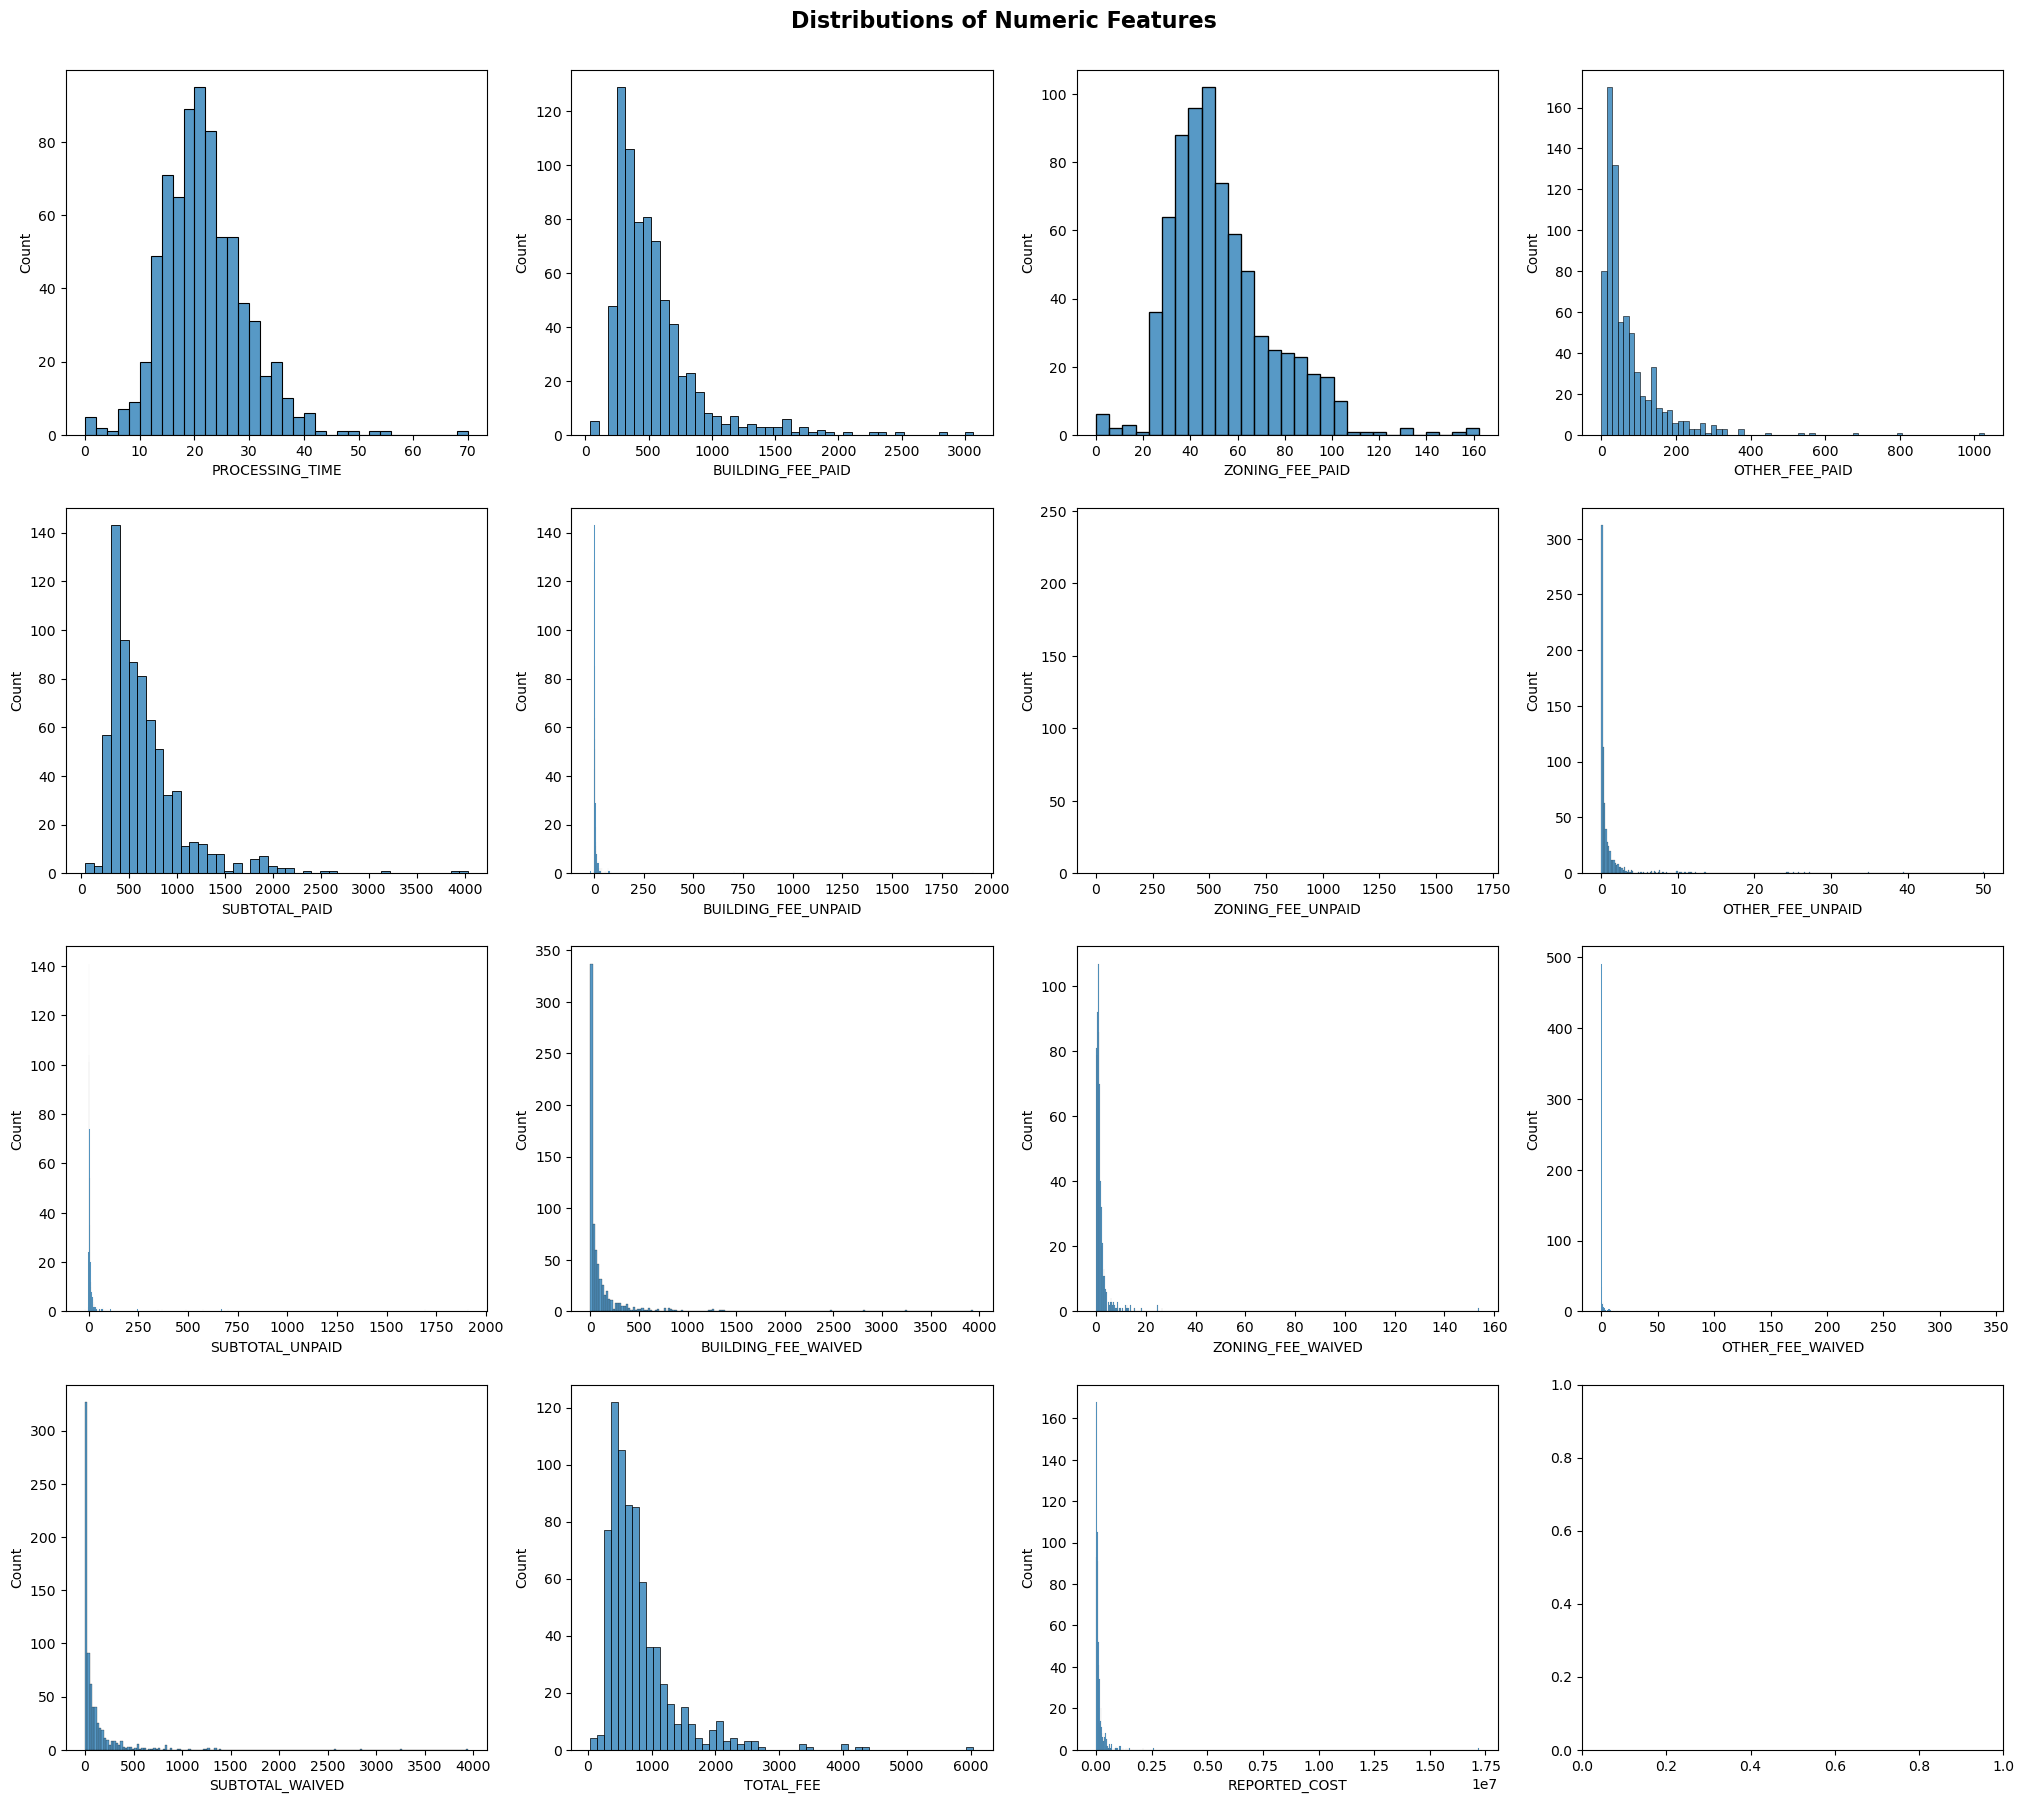

In [80]:
#to reduce the time to plot, groupby census tract and take the mean
df_num_exploration_mean=df_num.groupby('CENSUS_TRACT').mean().applymap(lambda x: round(x,2))

#plot a distribution of all numeric variables
fig, axes=plt.subplots(4, 4, figsize = (25, 20))
fig.suptitle('Distributions of Numeric Features', fontsize=16, fontweight='bold')
i = 1
for column in df_num_exploration_mean.columns:
    plt.subplot(4, 4, i)
    sns.histplot(data = df_num_exploration_mean[column])
    i += 1

plt.subplots_adjust(top=0.95)
plt.show()

* There are many outliers which result in long distribution tails
* Let's aim to normalize data distributions by applying a log transformation to the data

* Note for each type of payment, such as Subtotal, Building_Fee, Zoning_Fee and Other_Fee there are 3 categories - Paid, Unpaid and Waived
* Given that they all point towards the same type of payment, let's drop Unpaid and Waived Categories to avoid making to many multicollinear features

In [81]:
col_drop=[]

for i in get_columns_with_regex(df_num,'UNPAID').columns:
    col_drop.append(i)
for i in get_columns_with_regex(df_num,'WAIVED').columns:
    col_drop.append(i)  

print(col_drop)

['BUILDING_FEE_UNPAID', 'ZONING_FEE_UNPAID', 'OTHER_FEE_UNPAID', 'SUBTOTAL_UNPAID', 'BUILDING_FEE_WAIVED', 'ZONING_FEE_WAIVED', 'OTHER_FEE_WAIVED', 'SUBTOTAL_WAIVED']


In [82]:
#drop for filtered dataframe
df_num=df_num.drop(columns=col_drop)

#repeat for the main dataframe
permits_wip_4=permits_wip_4.drop(columns=col_drop);

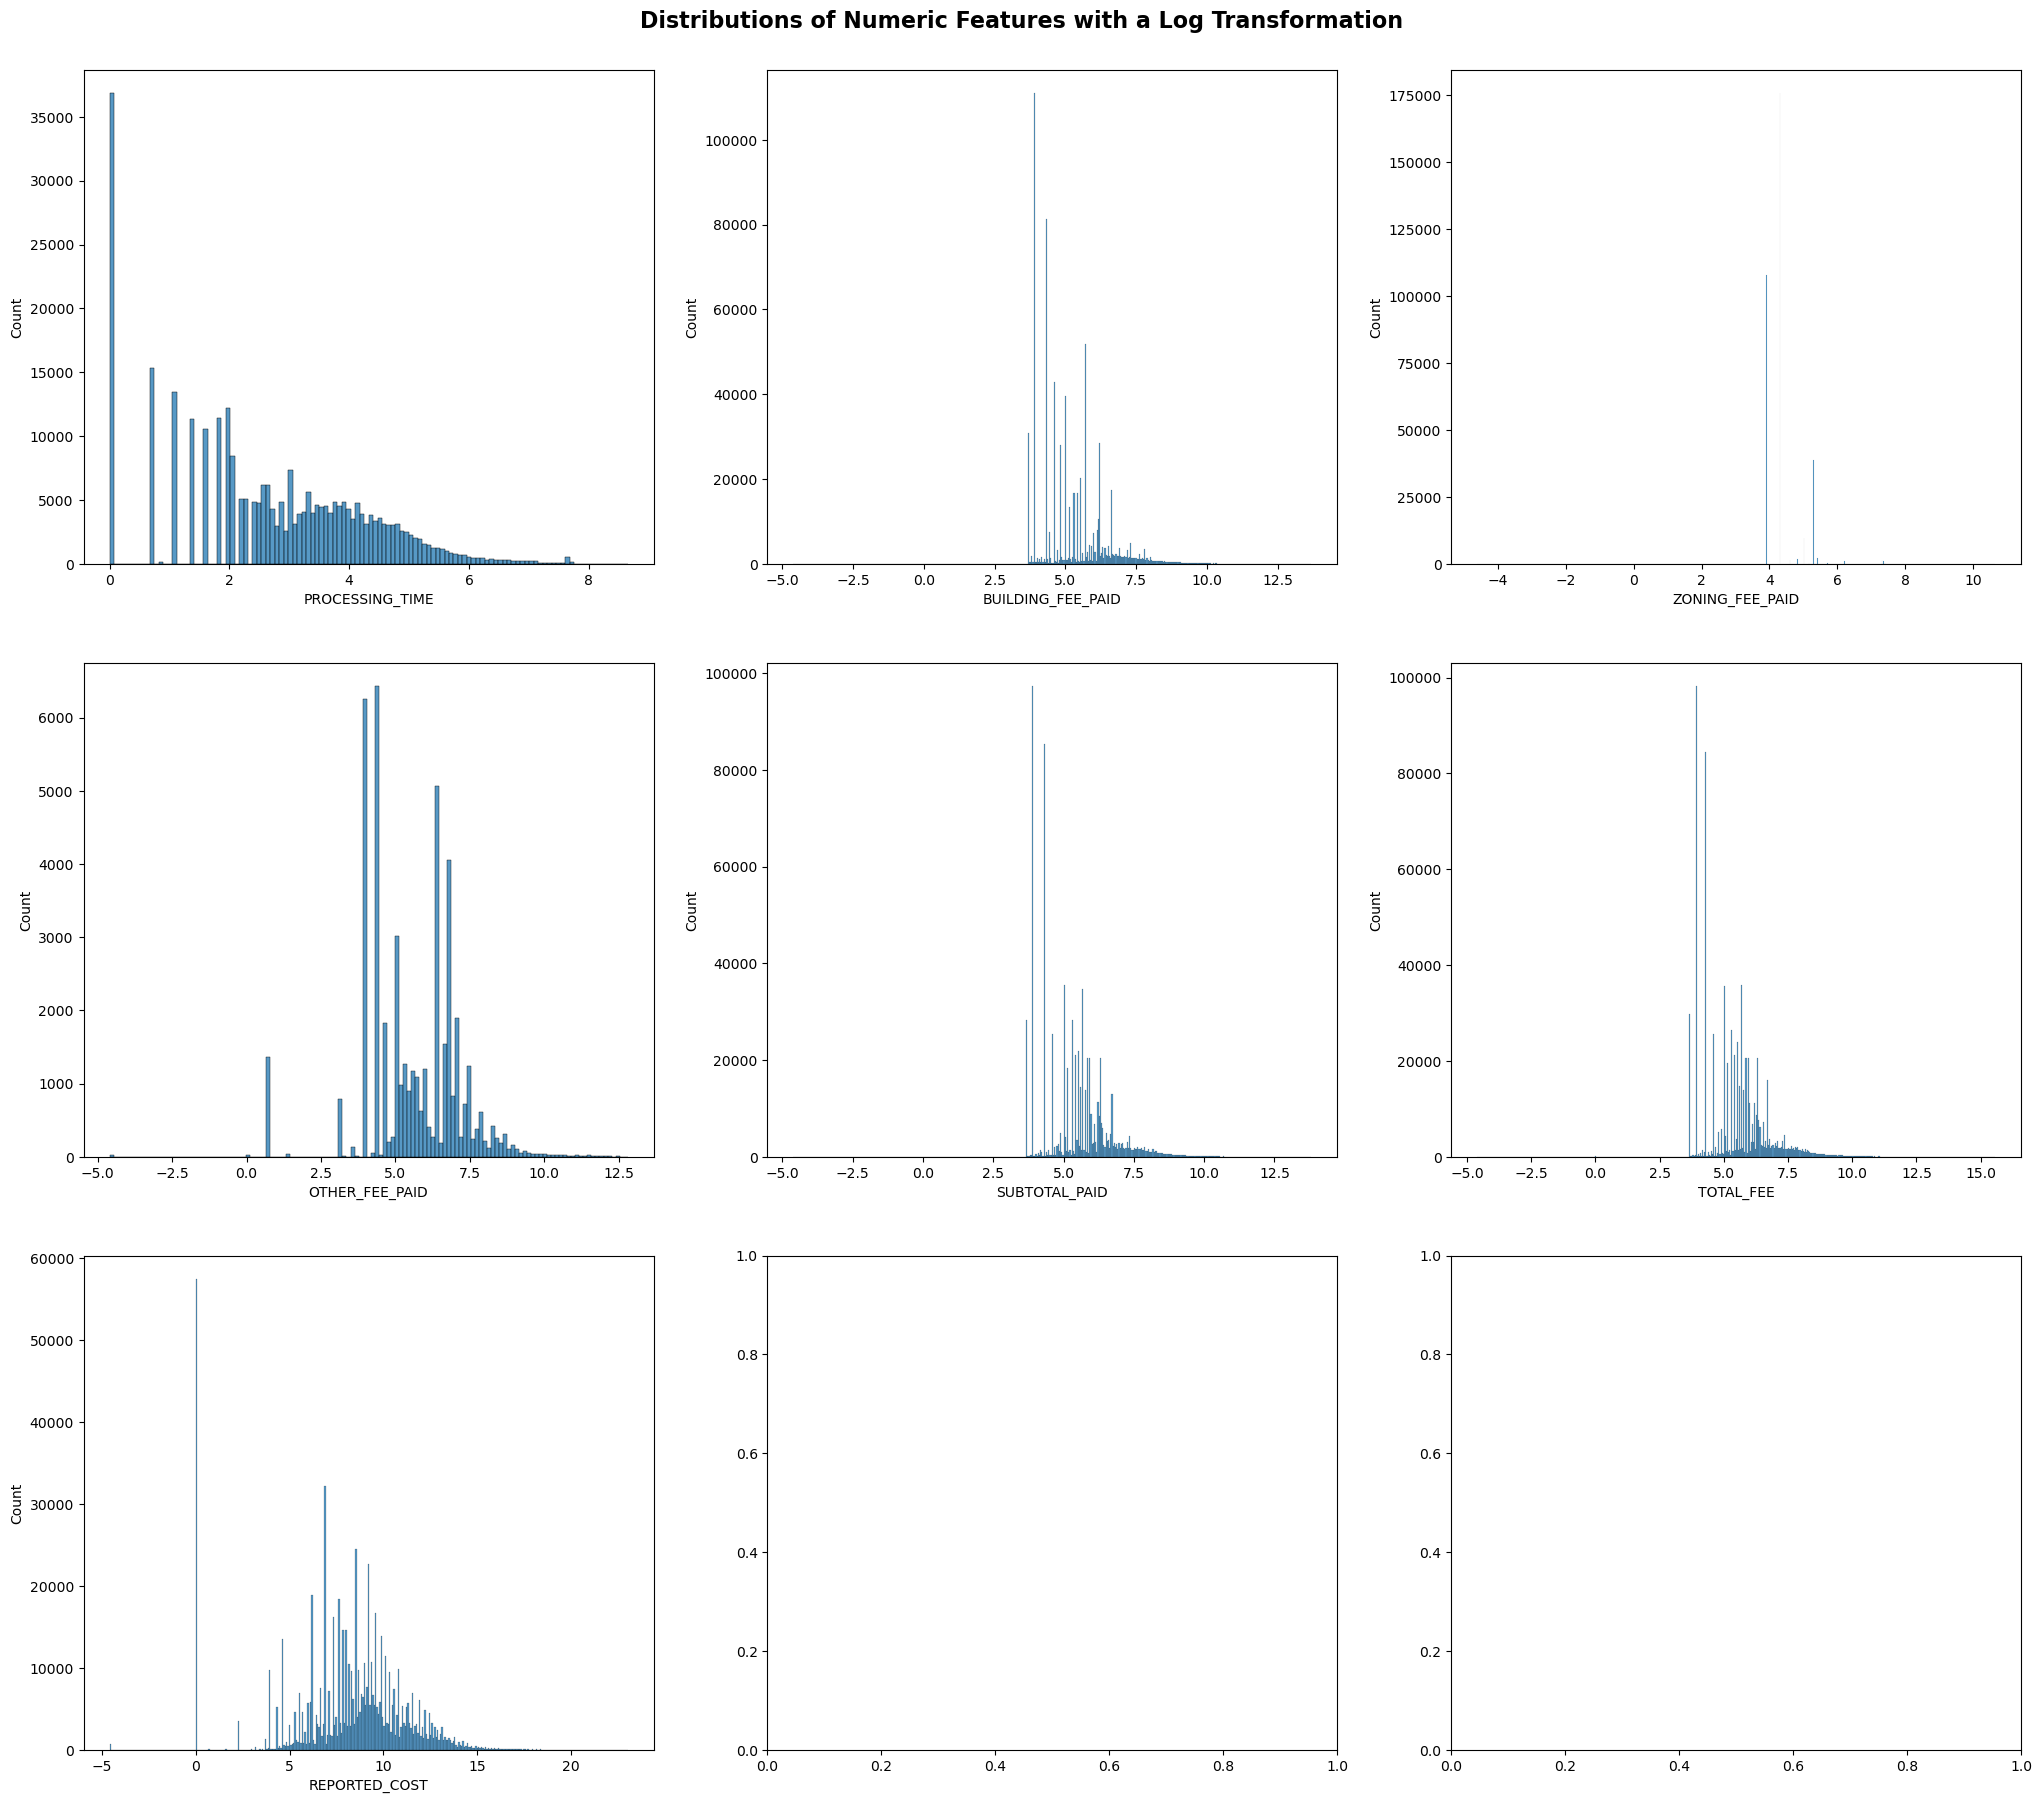

In [83]:
df_log=df_num.copy()
for col in df_num.drop(columns='CENSUS_TRACT').columns:
    df_log[col]=np.log(df_num[col])

#groupby census tract and take the mean
df_num_exploration_mean=df_log.groupby('CENSUS_TRACT').mean()

#plot a distribution of all numeric variables
fig, axes=plt.subplots(3, 3, figsize = (25, 20))
fig.suptitle('Distributions of Numeric Features with a Log Transformation', fontsize=16, fontweight='bold')
i = 1
for column in df_log.drop(columns='CENSUS_TRACT').columns:
    plt.subplot(3, 3, i)
    sns.histplot(data = df_log[column])
    i += 1

plt.subplots_adjust(top=0.95)
plt.show()

Applying log transformation helped to normalize data

* However, before applying log transformation, let's address the following observations:
* `Reported_Cost` : there is a spike at 0
  * means a lot of datapoints had reported cost states at 1 which might skew the results
  * replace 1 and values very close to 1 with an appropriate value
* `Zoning_Fee_Waived`, `Zoning_Fee_Unpaid`, `Zoning_Fee_Paid` columns appear to have extremely low variance
  * let's consider these columns closer and look at their value counts

`Reported_Cost`</br>
Investigate if reported cost of 1 or close to 1 could be replaced with a more appropriate value, since it is likely to be a missing value

In [84]:
#consider the distrubtion of unique reported costs stated on the applications
permits_wip_4['REPORTED_COST'].value_counts()

1.0          57419
0.0          31567
1000.0       30737
5000.0       22362
10000.0      18982
             ...  
43365.0          1
10066.0          1
25138.0          1
8940000.0        1
26506.0          1
Name: REPORTED_COST, Length: 45222, dtype: int64

* Values of 0 and 1 appear to be unrealistic

In [85]:
print(f"Reported cost is set to 0 or 1 for {permits_wip_4['REPORTED_COST'].isin([0,1]).sum()} which is {permits_wip_4['REPORTED_COST'].isin([0,1]).sum()*100/permits_wip_4.shape[0]:.2f}% of all datapoints")

Reported cost is set to 0 or 1 for 88986 which is 12.18% of all datapoints


* What permit types have the reported cost set at 0 or 1

In [86]:
permits_wip_4[permits_wip_4['REPORTED_COST'].isin([0,1])]['PERMIT_TYPE'].value_counts()

EASY PERMIT PROCESS      34553
ELECTRIC WIRING          25817
WRECKING/DEMOLITION      14234
SCAFFOLDING               7055
REINSTATE REVOKED PMT     3128
SIGNS                     2289
RENOVATION/ALTERATION      937
ELEVATOR EQUIPMENT         711
NEW CONSTRUCTION           243
FOR EXTENSION OF PMT        17
PORCH CONSTRUCTION           2
Name: PERMIT_TYPE, dtype: int64

* Let's try to replace most of 0 and 1 in the reported cost by taking the average cost for each permit type for each census tract
* Keeping in mind that some census tracts, might not have applications of a specific type

In [87]:
# Replace all 0 values in the 'REPORTED_COST' column with NaN values
permits_wip_4['REPORTED_COST']=permits_wip_4['REPORTED_COST'].replace({0:np.nan,1:np.nan})

# Group the DataFrame by 'CENSUS_TRACT' and 'PERMIT_TYPE', then fill any NaN values in the 'REPORTED_COST' column with the mean value of that group
permits_wip_4['REPORTED_COST']=permits_wip_4.groupby(['CENSUS_TRACT','PERMIT_TYPE'])['REPORTED_COST'].transform(lambda x: x.fillna(x.mean()))

In [88]:
print(f"Reported cost is set to 0 or 1 for {permits_wip_4['REPORTED_COST'].isna().sum()} which is {permits_wip_4[['REPORTED_COST']].isna().sum()[0]*100/permits_wip_4.shape[0]:.2f}% of all datapoints")

Reported cost is set to 0 or 1 for 2261 which is 0.31% of all datapoints


* 2261 is a significant reduction from 88986
* let's consider which reported costs are still missing by displaying the value count of the permit types with missing reported cost

In [89]:
permits_wip_4[permits_wip_4['REPORTED_COST'].isna()]['PERMIT_TYPE'].value_counts()

REINSTATE REVOKED PMT    1564
SCAFFOLDING               421
WRECKING/DEMOLITION       257
FOR EXTENSION OF PMT       15
SIGNS                       2
ELECTRIC WIRING             2
Name: PERMIT_TYPE, dtype: int64

* Let's fill the remaining null values for reported cost with the average reported cost for the permit type

In [90]:
# Group the DataFrame by 'PERMIT_TYPE' only, then fill any remaining NaN values in the 'REPORTED_COST'column with the mean value of the permit type
permits_wip_4['REPORTED_COST']=permits_wip_4.groupby('PERMIT_TYPE')['REPORTED_COST'].transform(lambda x: x.fillna(x.mean()))

In [91]:
#now all missing values for the reported cost should have been filled in
print(f"Reported cost is still missing for {permits_wip_4['REPORTED_COST'].isna().sum()} rows")

Reported cost is still missing for 0 rows


In [92]:
permits_wip_4['REPORTED_COST'].value_counts().sort_index()[0:10]

0.01      789
0.10       17
2.00      139
2.25        1
2.80        1
3.00       27
3.25        1
3.34        4
3.40        9
4.00       15
5.00       47
6.00        6
7.00        6
8.00        4
9.00        4
10.00    4027
Name: REPORTED_COST, dtype: int64

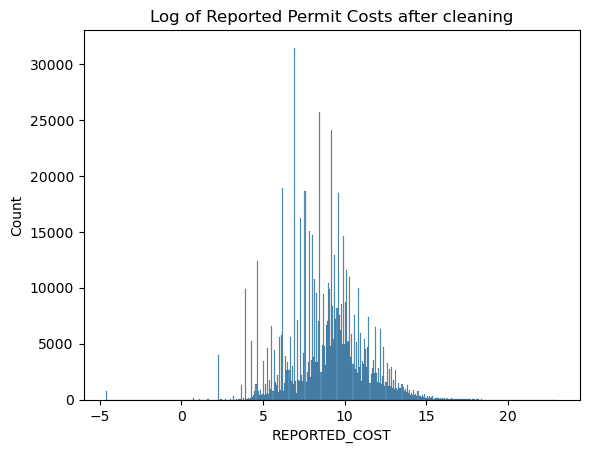

In [93]:
sns.histplot(data = np.log(permits_wip_4['REPORTED_COST']))
plt.title("Log of Reported Permit Costs after cleaning")
plt.show()

After cleaning, the peak at 0 was removed and the data distribution is closer to normal distribbution

Consider `Zoning_Fee_Paid`

In [94]:
permits_wip_4['ZONING_FEE_PAID'].value_counts().sort_index()

0.00        386078
0.01            25
0.75             1
1.00             2
12.50            1
             ...  
26757.80         1
28912.00         1
31748.00         1
40102.50         1
42123.42         1
Name: ZONING_FEE_PAID, Length: 1408, dtype: int64

Most of the values are at 0, which explains why 75% percentile was at zero and why histograms appear sparse. Let's keep this variable as numeric for now, but in the future could be converted into a categorical variable based on the specific amount paid for zoning

* Apply log transformation to all numeric columns
* Important to consider that many of the columns in the dataframe contain zeros
* Log transformation should not be applied to columns containing zeros because the logarithm of zero is undefined

In [95]:
#define a function to Replaces all zeros and negative values in a DataFrame
#this is required before applying a log transformation

def replace_zeros_and_neg(dataframe,skip_columns=['CENSUS_TRACT']):
    """
    Use:
        Replaces all zeros and negative values in a DataFrame with a very small non-zero value.

    Inputs:
        dataframe (pandas.DataFrame): The input DataFrame.
        skip_columns (list): List of columns to skip, default = ['CENSUS_TRACT']
    Returns:
        pandas.DataFrame: The modified DataFrame.
    """
    
    small_value=1e-10

    # Create a copy to avoid modifying the original
    df = dataframe.copy()

    # Iterate over each column in the DataFrame
    for col in df.columns:

        # Check if the column has numeric data and is not a column to skip
        if pd.api.types.is_numeric_dtype(df[col]) and col not in skip_columns:

            # Replace the zeros and negative values with the small_value
            mask=(df[col]<= 0)
            df.loc[mask,col]=small_value

    return df


In [96]:
#replace zeros before applying log transformation
df_temp=replace_zeros_and_neg(permits_wip_4)

# Get the list of numeric column names
num_cols = df_temp.drop(columns='CENSUS_TRACT').select_dtypes(include=[np.number]).columns.tolist()

# Apply log transformation to numeric columns
df_log = np.log(df_temp[num_cols])

# Add '_log' suffix to column names
df_log.columns = ['LOG_'+ col for col in num_cols]

# Concatenate the original dataframe (dropping original column) with the log transformed dataframe
permits_wip_5 = pd.concat([df_temp.drop(num_cols, axis=1), df_log], axis=1)

In [97]:
#check the dataframe
overview(permits_wip_5)

The dataframe shape is (730511, 15)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,EASY PERMIT PROCESS
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
ISSUE_DATE,object,0,0.0,01/03/2006,02/24/2023,11/09/2022
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,REPAIR SERVICE,REPLACE(2)WATER HEATERS AND ALL ASSOCIATED PIP...
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,CONTRACTOR-GENERAL CONTRACTOR
CONTACT_1_CITY,object,0,0.0,CHICAGO,SOMERSET,CHICAGO
CONTACT_1_STATE,object,0,0.0,IL,NJ,IL
CENSUS_TRACT,int32,0,0.0,220702,530503,150200
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,-23.025851,-23.025851


---
*<center><h3>Categorical Columns<center><h3>*

* Let's now consider all the categorical columns

In [98]:
df_obj

,PERMIT_TYPE,REVIEW_TYPE,ISSUE_DATE,WORK_DESCRIPTION,CONTACT_1_TYPE,CONTACT_1_CITY,CONTACT_1_STATE
0,RENOVATION/ALTERATION,STANDARD PLAN REVIEW,01/03/2006,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL
1,NEW CONSTRUCTION,STANDARD PLAN REVIEW,03/29/2006,"new construction, erect 3 story slab on grade ...",ARCHITECT,CHICAGO X,IL
2,SIGNS,SIGN PERMIT,01/12/2006,north elevation 386431,CONTRACTOR-ELECTRICAL,ROLLING MEADOWS,IL
3,RENOVATION/ALTERATION,SELF CERT,01/26/2006,Interior alteration of existing partial 34th f...,SELF CERT ARCHITECT,CHICAGO X,IL
4,RENOVATION/ALTERATION,SELF CERT,01/21/2006,Interior alterations to the retail space on th...,SELF CERT ARCHITECT,DEERFIELD X,IL
...,...,...,...,...,...,...,...
730506,EASY PERMIT PROCESS,EASY PERMIT,02/24/2023,SOLAR PANEL PERMIT. ERECT A PHOTOVOLTAIC ARRA...,STRUCTURAL ENGINEER,HOUSTON,TX
730507,EASY PERMIT PROCESS,EASY PERMIT WEB,02/24/2023,FENCES: 165FT 0IN X 6FT 0IN: QTY 1 (not to be ...,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL
730508,ELECTRIC WIRING,EASY PERMIT WEB,02/24/2023,"TECH WILL PULL 100 CAT-6 CABLES, TERMINATE, AN...",CONTRACTOR-ELECTRICAL,LENEXA,KS
730509,EASY PERMIT PROCESS,EASY PERMIT,02/24/2023,REVISION TO PERMIT NO 100988130 TO CHANGE ELEC...,CONTRACTOR-ELECTRICAL,CHICAGO,IL


* Consider how the number of unique categories for each column changed over the years
* Checking this helps to identify 
  * if any of the years have massing data
  * if there were any changes to the categories (in particular, permit_type and review_type)
    * for example, if a new permit type was added later on it would not be present in the earlier years and have data incomplete

In [99]:
#Ensure ISSUE_DATE format is datetime
df_obj['ISSUE_DATE']=df_obj['ISSUE_DATE'].astype('datetime64')

unique_yearly=df_obj.groupby(df_obj['ISSUE_DATE'].dt.year).nunique().drop(columns='ISSUE_DATE')
unique_yearly

,PERMIT_TYPE,REVIEW_TYPE,WORK_DESCRIPTION,CONTACT_1_TYPE,CONTACT_1_CITY,CONTACT_1_STATE
ISSUE_DATE,,,,,,
2006,11,10,37483,26,680,79
2007,11,10,36499,26,635,72
2008,11,10,31280,26,612,72
2009,10,10,30485,26,627,66
2010,9,10,30315,23,617,69
2011,9,10,30362,22,643,47
2012,9,10,31787,21,652,58
2013,9,10,33989,22,679,66
2014,9,10,37332,22,702,62


* Number of distinct permit types decreased from 11 in 2006 to 9 in 2023
  * Means that the use of some permit types was discontinued
* Number of distinct review types increased from 10 to 11
  * Means that there was a new review type added
* Note, 2023 has fewer data since the dataset was downloaded on Feb, 26

***
### Permit Type

* Let's preview the distribution of different permit types by the total number of planning applications for each permit type

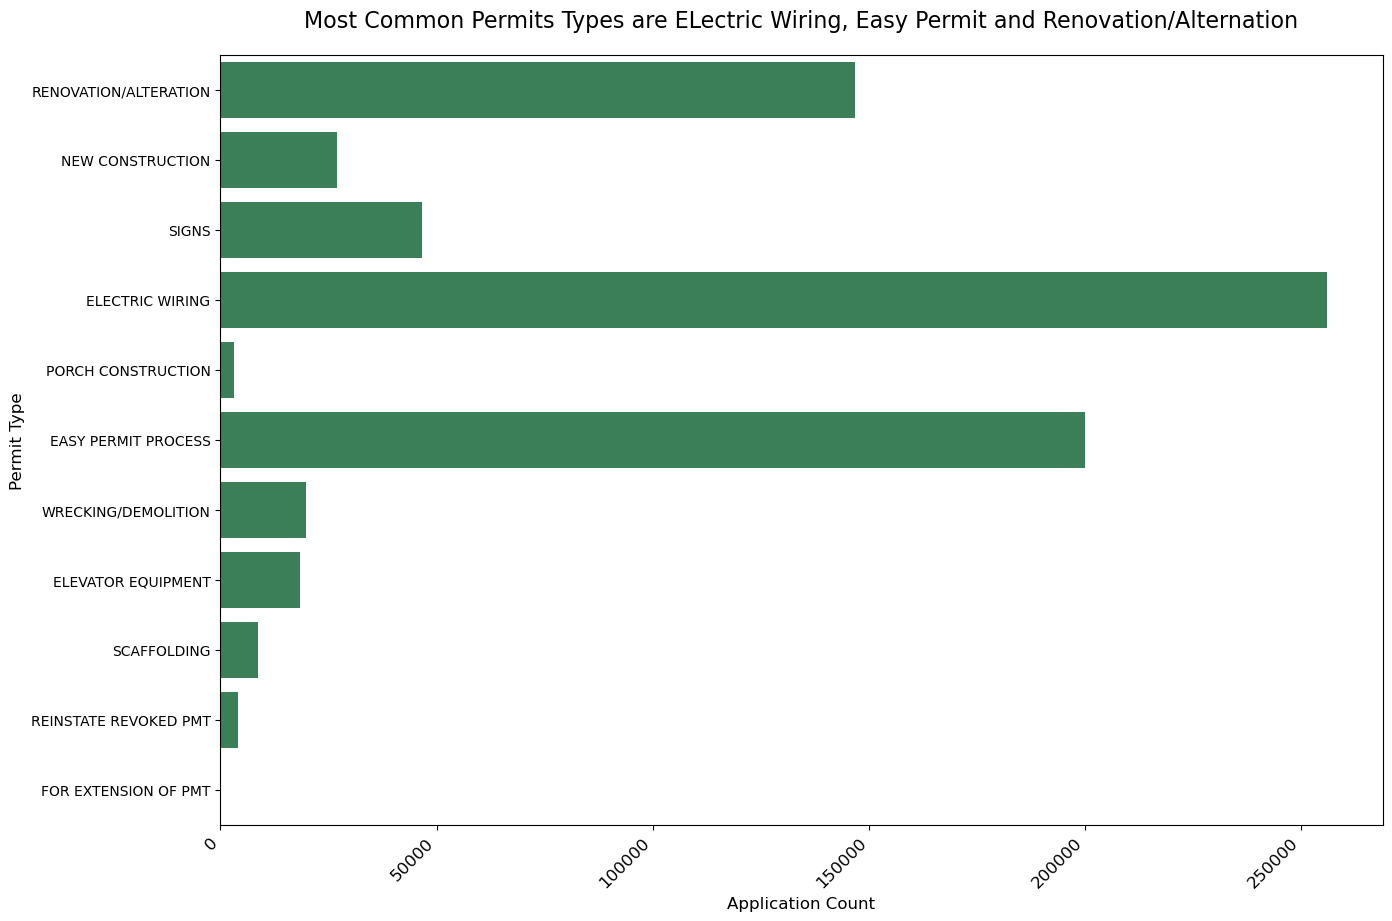

In [100]:
plt.figure(figsize=(15,10))

ax=sns.countplot(data=df_obj,y='PERMIT_TYPE',color='seagreen')
ax.set_title('Most Common Permits Types are ELectric Wiring, Easy Permit and Renovation/Alternation', fontsize=16, pad=20)

plt.xticks(rotation=45, ha='right', fontsize=12)

plt.ylabel('Permit Type', fontsize=12)
plt.xlabel('Application Count', fontsize=12)

plt.show()

**Graph Interpretation and Predictions for the impact of each variable on gentrification**
* Electrical wiring is the most frequent type of a permit type
  * Electrical Wiring repairs would be happening in all kinds of districts, but smaller portions of electric wiring permits relative to other permits might indicate an increased likelihood of gentrification
* Second most frequent type is the Easy Permit Process:
  * External research reveals that this type of permit "is a streamlined permitting process for small, simple home and building improvement projects" for which no architectural plans have to be provided [resource](https://www.chicago.gov/city/en/depts/bldgs/provdrs/permits/svcs/easy-permits.html)
  * This category is similar to renovation/alteration but does require the input of an architect. 
* Third most frequent type is Renovation/Alteration
  * One could speculate that Renovation/Alteration would be a better indicator than Easy Permit Process because if people intend to conduct work without an architect, they are likely to be the property owner and are not looking to move in/put
  * Note, this is just a prediction, and this would need to be checked after modelling the data to see if there is any correlation between renovation/alteration permits and gentrification


* Some types have very few building applications recorded
  * Let's look at their counts to understand their distribution better

In [101]:
#Preview the absolute counts for each permit type
df_obj['PERMIT_TYPE'].value_counts()

ELECTRIC WIRING          256012
EASY PERMIT PROCESS      199935
RENOVATION/ALTERATION    146854
SIGNS                     46707
NEW CONSTRUCTION          26974
WRECKING/DEMOLITION       19730
ELEVATOR EQUIPMENT        18456
SCAFFOLDING                8649
REINSTATE REVOKED PMT      4040
PORCH CONSTRUCTION         3096
FOR EXTENSION OF PMT         58
Name: PERMIT_TYPE, dtype: int64

* 'FOR EXTENSION OF PMT' had only in 58 planning permits. Consider whether it is a special type of application which would be statistiaclly relevant or whether its use was discontinued instead

In [102]:
#recall how the number of distinct permit types changed over the years
list(unique_yearly['PERMIT_TYPE'])

[11, 11, 11, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

* Check the differnce between the distinct permit types in 2006 and 2022

In [103]:
#use sets and symmetric_difference to check which permit types were added
distict_permit_types_2006=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2006]['PERMIT_TYPE'].unique())
distict_permit_types_2022=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2022]['PERMIT_TYPE'].unique())
distict_permit_types_2006.symmetric_difference(distict_permit_types_2022)

{'FOR EXTENSION OF PMT', 'PORCH CONSTRUCTION'}

* 'FOR EXTENSION OF PMT', 'PORCH CONSTRUCTION' were permit types in 2006 but were discontinued by 2022. Hence, using them for future predictions will not be useful
* 'FOR EXTENSION OF PMT' with only 58 datapoints is not a useful metric, let's also drop it
* Rename 'FOR EXTENSION OF PMT', 'PORCH CONSTRUCTION' to 'DROP'
* Remember to drop `'PERMIT_TYPE_DROP'` before modelling

In [104]:
#rename permit types that cannot be used as a useful metric for the
permits_wip_5['PERMIT_TYPE']=permits_wip_5['PERMIT_TYPE'].replace({'FOR EXTENSION OF PMT':'DROP','PORCH CONSTRUCTION':'DROP'})

* Consider reported cost, as more investment into a neighbourhood, means it is more likely it is to gentrify
* Consider the distribution of reported costs for each permit type

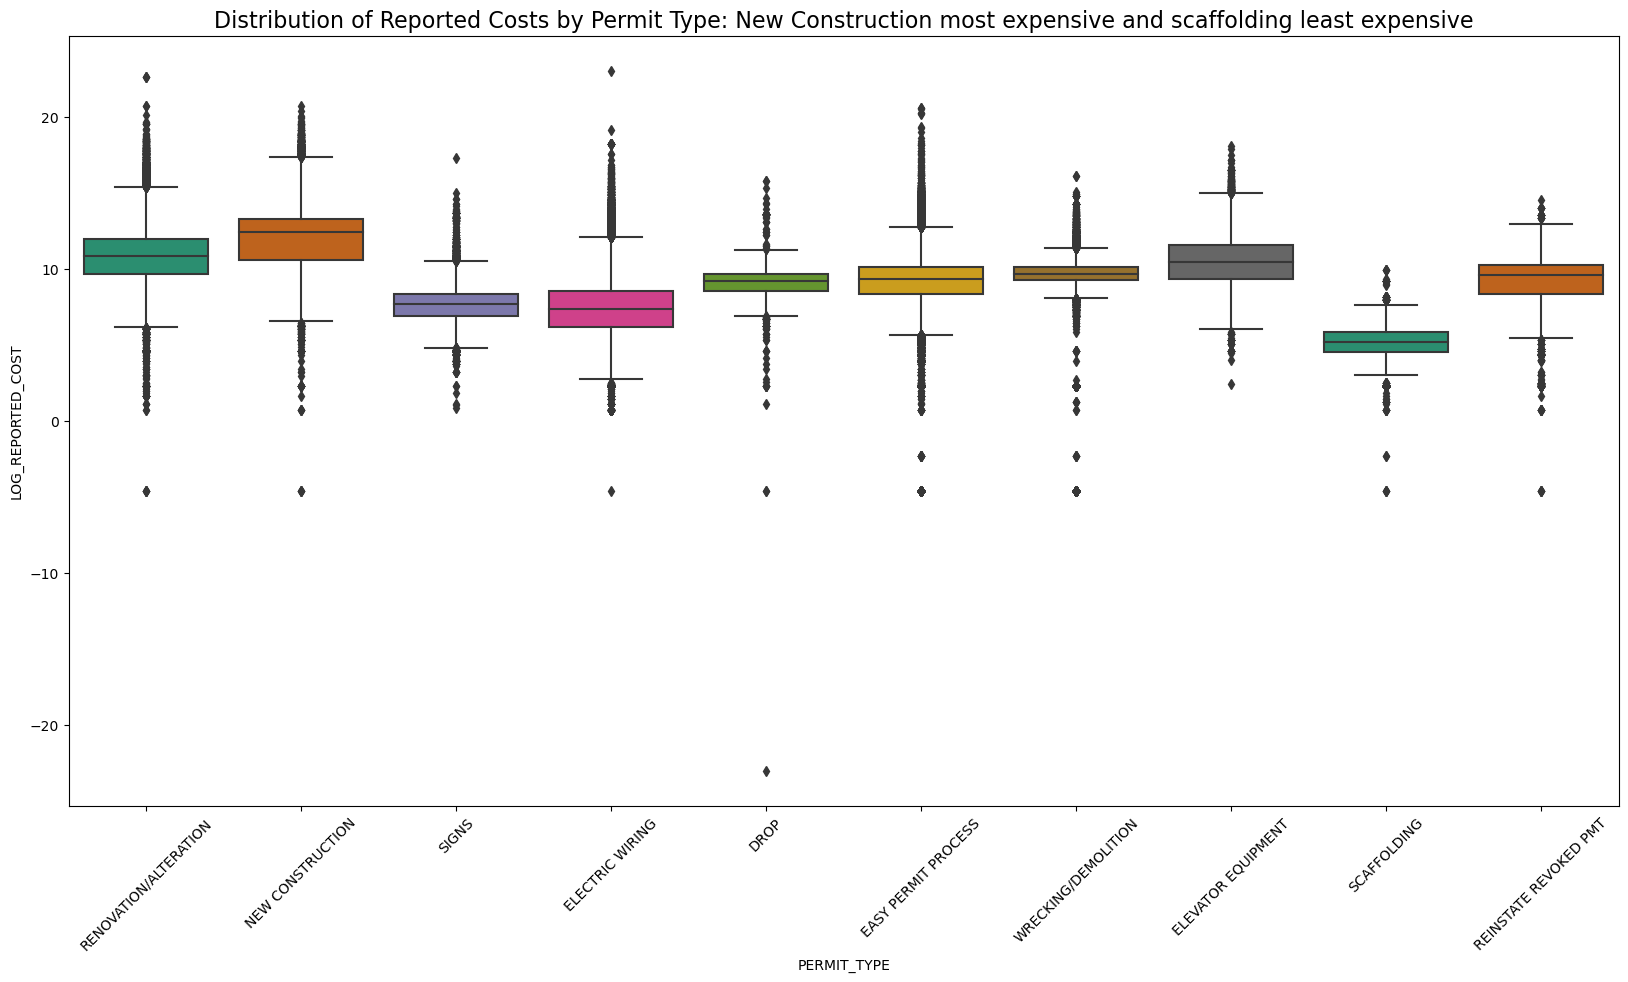

In [105]:
fig, ax = plt.subplots(figsize=(20,10))

sns.boxplot(data=permits_wip_5, x='PERMIT_TYPE', y='LOG_REPORTED_COST', palette=sns.color_palette('Dark2'))

plt.title('Distribution of Reported Costs by Permit Type: New Construction most expensive and scaffolding least expensive', fontsize=16)

plt.xticks(rotation=45);

* Permit type with the highest median reported cost is New Construction
* The lowest reported cost is for scaffolding

***
* ***What is the relationship between Permit Type and Review Type?***

In [106]:
#groupby REVIEW_TYPE & PERMIT_TYPE to view unique pair combinations
check=permits_wip_5.groupby(['REVIEW_TYPE','PERMIT_TYPE']).size().reset_index()[['REVIEW_TYPE','PERMIT_TYPE']]
check

,REVIEW_TYPE,PERMIT_TYPE
0,CONVEYANCE DEVICE PERMIT,ELEVATOR EQUIPMENT
1,DEMOLITION PERMIT,WRECKING/DEMOLITION
2,DIRECT DEVELOPER SERVICES,NEW CONSTRUCTION
3,DIRECT DEVELOPER SERVICES,RENOVATION/ALTERATION
4,EASY PERMIT,DROP
5,EASY PERMIT,EASY PERMIT PROCESS
6,EASY PERMIT,NEW CONSTRUCTION
7,EASY PERMIT,REINSTATE REVOKED PMT
8,EASY PERMIT,RENOVATION/ALTERATION
9,EASY PERMIT,SCAFFOLDING


In [107]:
dup_pairs=[]
for i,row in check.iterrows():
    condition_one=(check[check['REVIEW_TYPE']==row['REVIEW_TYPE']]).shape[0]==1
    condition_two=(check[check['PERMIT_TYPE']==row['PERMIT_TYPE']]).shape[0]==1
    if condition_one&condition_two:
        dup_pairs.append((row['REVIEW_TYPE'],row['PERMIT_TYPE']))
dup_pairs

[('CONVEYANCE DEVICE PERMIT', 'ELEVATOR EQUIPMENT'),
 ('DEMOLITION PERMIT', 'WRECKING/DEMOLITION'),
 ('SIGN PERMIT', 'SIGNS')]

* The pairs of review and permit types above form a **one-to-one match**. One of them needs to be dropped
  * Let's drop the permit types and no review types, so then only one column `PERMIT_TYPE_DROP` has to be dropped before modelling
* Let's rename the permit types `'CONVEYANCE DEVICE PERMIT', 'WRECKING/DEMOLITION', 'SIGNS'` to be called `DROP`
* Remember to drop `'PERMIT_TYPE_DROP'` before modelling

In [108]:
permits_wip_5['PERMIT_TYPE']=permits_wip_5['PERMIT_TYPE'].replace({'ELEVATOR EQUIPMENT':'DROP','WRECKING/DEMOLITION':'DROP','SIGNS':'DROP'})

In [109]:
permits_wip_5['PERMIT_TYPE'].unique()

array(['RENOVATION/ALTERATION', 'NEW CONSTRUCTION', 'DROP',
       'ELECTRIC WIRING', 'EASY PERMIT PROCESS', 'SCAFFOLDING',
       'REINSTATE REVOKED PMT'], dtype=object)

***
# Review Type

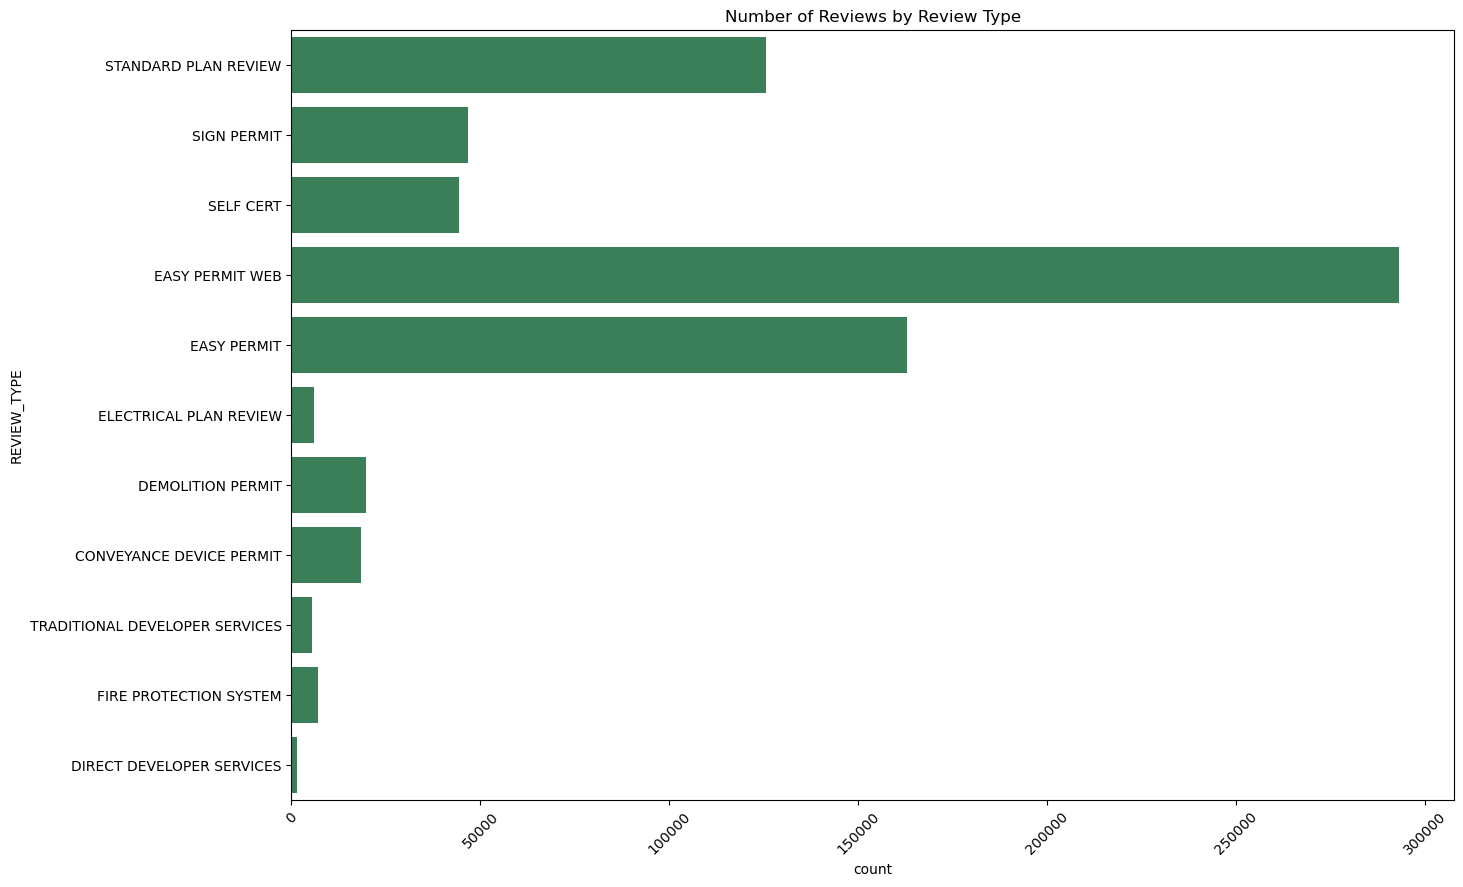

In [110]:
plt.figure(figsize=(15,10))
sns.countplot(data=df_obj,y='REVIEW_TYPE',color='seagreen',orient="h")
plt.title('Number of Reviews by Review Type')
plt.xticks(rotation=45);

**Graph Observations**
* EASY PERMIT WEB and EASY PERMIT both indicate towards an EASY PERMIT review
  * Note, combined EASY PERMIT WEB and EASY PERMIT **review** types do not indicate an EASY **permit** type
  * It might be relevant to the study how each permit was submitted. Let's keep the two categories separate
* DIRECT DEVELOPER SERVICES has the smallest count
  * Consider if it was present in all years

In [111]:
#preview the number of applications for each review types to confirm how many applications were categorized as Direct Developer Services
df_obj['REVIEW_TYPE'].value_counts(normalize=True)*100

EASY PERMIT WEB                   40.105488
EASY PERMIT                       22.304387
STANDARD PLAN REVIEW              17.199330
SIGN PERMIT                        6.393744
SELF CERT                          6.079032
DEMOLITION PERMIT                  2.700849
CONVEYANCE DEVICE PERMIT           2.526451
FIRE PROTECTION SYSTEM             0.948240
ELECTRICAL PLAN REVIEW             0.820111
TRADITIONAL DEVELOPER SERVICES     0.734417
DIRECT DEVELOPER SERVICES          0.187951
Name: REVIEW_TYPE, dtype: float64

* Direct developer services were only present in 0.19% of applications

In [112]:
#note: unique_yearly was a dataframe created earlier to calculate the number of unique categories for each year for each categorical column
print('Num of unique review types for each year in a chronological order',list(unique_yearly['REVIEW_TYPE']))

#dispplays counts of distinct review types for each year in a chronological order

Num of unique review types for each year in a chronological order [10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11]


* One Review Type was added between 2006 and 2023
* Check if it was `DIRECT DEVELOPER SERVICES`

In [113]:
distict_review_types_2006=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2006]['REVIEW_TYPE'].unique())
distict_review_types_2022=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2022]['REVIEW_TYPE'].unique())
distict_review_types_2006.symmetric_difference(distict_review_types_2022)

{'DIRECT DEVELOPER SERVICES'}

* DIRECT DEVELOPER SERVICES was only added in 2015. Hence, it will be missing in the early years.</br>
* While it is unlikely to be a good predictor in the current model due to the lack of datapoints with DIRECT DEVELOPER SERVICES, it might become a good predictor in the future
* Hence, let's not drop it but when running statistical tests be mindful that it might not show any correlations when the model is trained on the data from years before 2015

***
### CONTACT_1_TYPE

In [114]:
#display unique contact types
permits_wip_5['CONTACT_1_TYPE'].unique()

array(['OWNER AS GENERAL CONTRACTOR', 'ARCHITECT',
       'CONTRACTOR-ELECTRICAL', 'SELF CERT ARCHITECT', 'UNKNOWN',
       'CONTRACTOR-GENERAL CONTRACTOR', 'SIGN CONTRACTOR',
       'STRUCTURAL ENGINEER', 'OWNER', 'OWNER AS ARCHITECT & CONTRACTR',
       'OWNER OCCUPIED', 'CONTRACTOR-ELEVATOR', 'EXPEDITOR',
       'BUILDING OWNER', 'CONTRACTOR-WRECKING', 'CONTRACTOR-VENTILATION',
       'CONTRACTOR-PLUMBER/PLUMBING', 'OWNER AS ARCHITECT',
       'TENT CONTRACTOR', 'MASON - BRICK AND CONCRETE',
       'MASON - BRICK ONLY', 'MASONRY CONTRACTOR', 'CONTRACTOR-HEATING',
       'PLUMBING CONTRACTOR', 'MASON - CONCRETE ONLY',
       'RESIDENTAL REAL ESTATE DEV', 'CONTRACTOR-REFRIGERATION'],
      dtype=object)

Text(0.5, 1.0, 'Number of applications for each Contact Type')

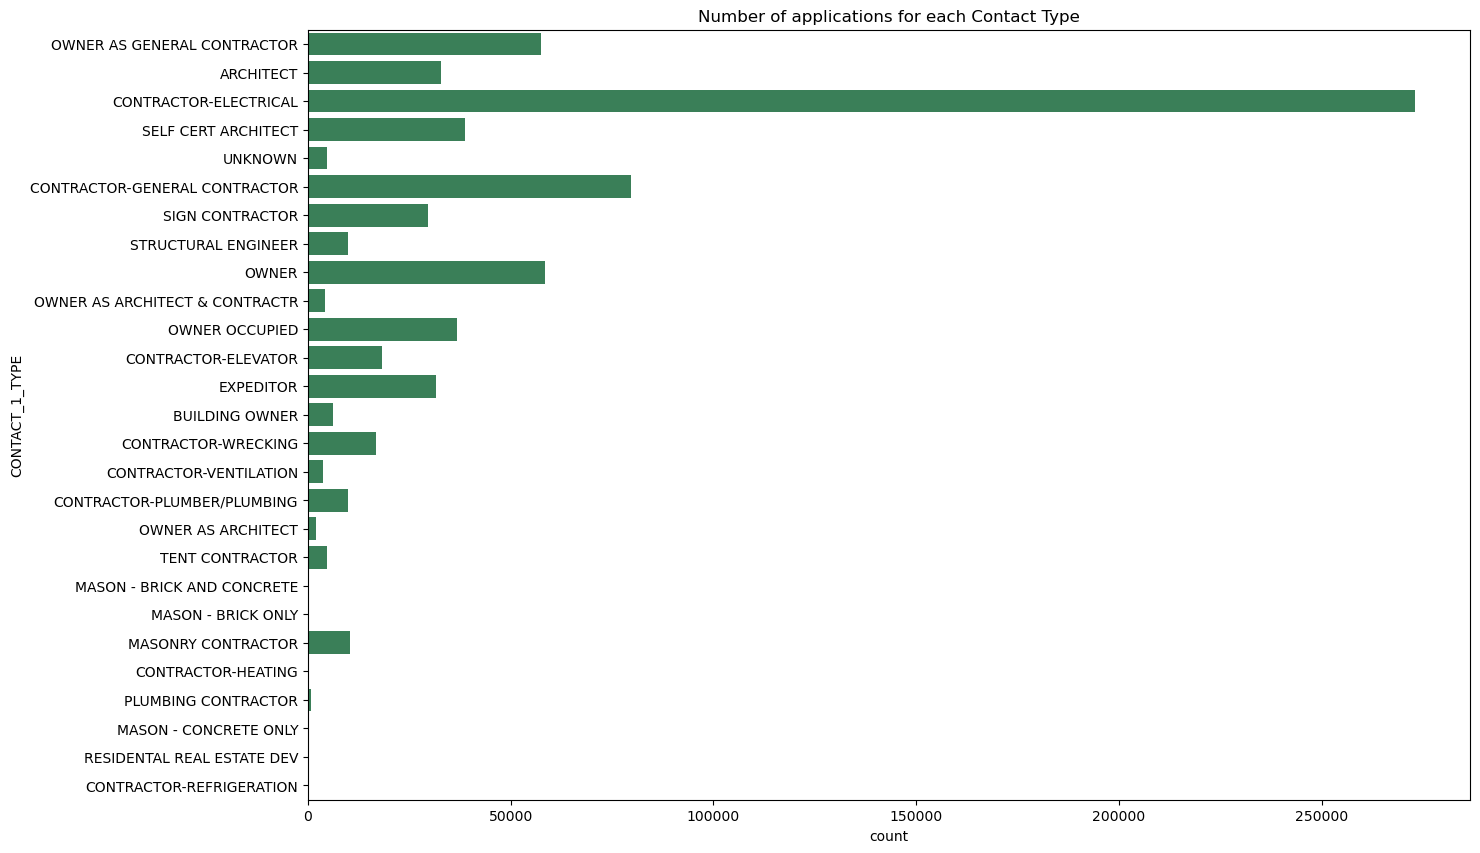

In [115]:
plt.figure(figsize=(15,10))
sns.countplot(data=df_obj,y='CONTACT_1_TYPE',color='seagreen',orient="h")
plt.title('Number of applications for each Contact Type')

**Graph Observations**
* CONTRACTOR-ELECTRICAL is the most frequent contact type
  * which likely corresponds to the Electrical Permit type which was mentioned earlier
  * This might cause multicollinearity, it will be essential to check for multicollinearity before modelling
* 'MASON - BRICK AND CONCRETE', 'MASON - BRICK ONLY' and 'MASON - CONCRETE ONLY' have very low counts but are similar
  * consider if they can be grouped together

In [116]:
#absolute values
df_obj['CONTACT_1_TYPE'].value_counts()

CONTRACTOR-ELECTRICAL             272995
CONTRACTOR-GENERAL CONTRACTOR      79675
OWNER                              58533
OWNER AS GENERAL CONTRACTOR        57524
SELF CERT ARCHITECT                38748
OWNER OCCUPIED                     36737
ARCHITECT                          32752
EXPEDITOR                          31478
SIGN CONTRACTOR                    29689
CONTRACTOR-ELEVATOR                18284
CONTRACTOR-WRECKING                16678
MASONRY CONTRACTOR                 10383
CONTRACTOR-PLUMBER/PLUMBING         9975
STRUCTURAL ENGINEER                 9840
BUILDING OWNER                      6122
UNKNOWN                             4773
TENT CONTRACTOR                     4665
OWNER AS ARCHITECT & CONTRACTR      4238
CONTRACTOR-VENTILATION              3750
OWNER AS ARCHITECT                  1874
PLUMBING CONTRACTOR                  816
MASON - BRICK AND CONCRETE           315
MASON - BRICK ONLY                   224
CONTRACTOR-HEATING                   202
CONTRACTOR-REFRI

Note 1:
* RESIDENTAL REAL ESTATE DEV has only 2 counts, let's rename it to `DROP`
* Remember to drop `'CONTACT_1_TYPE_DROP'` before modelling

In [117]:
permits_wip_5['CONTACT_1_TYPE']=permits_wip_5['CONTACT_1_TYPE'].replace({'RESIDENTAL REAL ESTATE DEV':'DROP'})

Note 2:
* Categories `'MASON - BRICK AND CONCRETE'`, `'MASON - BRICK ONLY'` and `'MASON - CONCRETE ONLY'` all have low counts
* Let's merge them all together into **'MASON - BRICK AND CONCRETE'** since they all refer to masonry contractor working with brick and concrete


In [118]:
permits_wip_5['CONTACT_1_TYPE']=permits_wip_5['CONTACT_1_TYPE'].replace({'MASON - BRICK ONLY':'MASON - BRICK AND CONCRETE','MASON - CONCRETE ONLY':'MASON - BRICK AND CONCRETE'})

***
### CONTACT_1_CITY

* Evaluating the contact city of the person responsible for the project might indicate if people outside of Chicago are investing into the neighbourhood or if architects from another city were involved

In [119]:
print(permits_wip_5['CONTACT_1_CITY'].value_counts()[0:25])
print('\n')
print(permits_wip_5['CONTACT_1_CITY'].value_counts().shape[0])

CHICAGO              341031
CHICAGO X             15248
MINOOKA               12798
OAK BROOK             12758
CHGO                  11960
NORTHBROOK            10484
ELK GROVE VILLAGE     10323
UNKNOWN               10305
IRVING                 8685
ADDISON                7723
LOMBARD                7555
DOWNERS GROVE          7102
SKOKIE                 6874
ARLINGTON HEIGHTS      5891
PARK RIDGE             5754
DES PLAINES            5333
SCHAUMBURG             5127
ELMHURST               4881
ELGIN                  4646
OAK LAWN               4504
SUMMIT                 4467
ROLLING MEADOWS        4457
GLENVIEW               4006
MELROSE PARK           3972
ALSIP                  3916
Name: CONTACT_1_CITY, dtype: int64


2576


* Let's rename apelling variatios of Chicago to CHICAGO

In [120]:
permits_wip_5['CONTACT_1_CITY'].value_counts()[1:16].index

Index(['CHICAGO X', 'MINOOKA', 'OAK BROOK', 'CHGO', 'NORTHBROOK',
       'ELK GROVE VILLAGE', 'UNKNOWN', 'IRVING', 'ADDISON', 'LOMBARD',
       'DOWNERS GROVE', 'SKOKIE', 'ARLINGTON HEIGHTS', 'PARK RIDGE',
       'DES PLAINES'],
      dtype='object')

* Let's select just top 5 cities, not to create too many one hot encoded variables

In [121]:
permits_wip_5['CONTACT_1_CITY']=permits_wip_5['CONTACT_1_CITY'].replace({'CHICAGO X':'CHICAGO','CHGO':'CHICAGO'})

#top 4 cities apart from Chicago to be one hot encoded later
cities=list(permits_wip_5['CONTACT_1_CITY'].value_counts()[1:5].index)
cities.append('CHICAGO')
permits_wip_5['CONTACT_1_CITY']=[x if x in cities else 'OTHER' for x in permits_wip_5['CONTACT_1_CITY']]

In [122]:
print(permits_wip_5['CONTACT_1_CITY'].value_counts()[0:25])

CHICAGO              368239
OTHER                315909
MINOOKA               12798
OAK BROOK             12758
NORTHBROOK            10484
ELK GROVE VILLAGE     10323
Name: CONTACT_1_CITY, dtype: int64


---
### CONTACT_1_STATE

* Similarly, contacts from other states might indicate increased chances of higher investments and potential gentrification

In [123]:
print(permits_wip_5['CONTACT_1_STATE'].value_counts()[0:25])
print('\n')
print(permits_wip_5['CONTACT_1_STATE'].value_counts().shape[0])

IL          684614
TX            9794
UNKNOWN       6903
IN            5345
CA            4784
WI            2698
UT            1841
ILLINOIS      1684
NJ            1537
FL            1158
IL.           1113
MI             982
NY             835
GA             765
60             716
ILL            671
OH             602
MO             599
KS             432
PA             343
MN             268
MA             248
CO             212
TN             200
AZ             182
Name: CONTACT_1_STATE, dtype: int64


220


In [124]:
permits_wip_5['CONTACT_1_STATE']=permits_wip_5['CONTACT_1_STATE'].replace({'ILLINOIS':'IL','ILL':'IL','IL.':'IL'})

In [125]:
#select a two most frequent states and NY to be one hot encoded
states=['IL','TX','NY']
permits_wip_5['CONTACT_1_STATE']=[x if x in states else 'OTHER' for x in permits_wip_5['CONTACT_1_STATE']]

In [126]:
permits_wip_5['CONTACT_1_STATE'].value_counts()

IL       688082
OTHER     31800
TX         9794
NY          835
Name: CONTACT_1_STATE, dtype: int64

In [127]:
#Create another feature that is the contact in IL state but not Chicago
condition_one=permits_wip_5['CONTACT_1_CITY'].isin(['UNKNOWN', 'OTHER'])
condition_two=permits_wip_5['CONTACT_1_STATE']!='IL'
permits_wip_5.loc[(condition_one&condition_two),'CONTACT_1_CITY']='CHICAGO_SUBURBS'

* Convert ISSUE_DATE to YEAR

In [128]:
permits_wip_5['YEAR']=permits_wip_5['ISSUE_DATE'].astype('datetime64').dt.year
permits_wip_5=permits_wip_5.drop(columns='ISSUE_DATE')

* All categoric columns apart from WORK_DESCRIPTION were not explored, WORK_DESCRIPTION column will be explored in notebook #3 using nlp

***

In [129]:
overview(permits_wip_5)

The dataframe shape is (730511, 15)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,RENOVATION/ALTERATION
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,SELF CERT
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,REPAIR SERVICE,Interior alterations to existing retail space ...
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,SELF CERT ARCHITECT
CONTACT_1_CITY,object,0,0.0,CHICAGO,CHICAGO_SUBURBS,CHICAGO_SUBURBS
CONTACT_1_STATE,object,0,0.0,IL,OTHER,OTHER
CENSUS_TRACT,int32,0,0.0,220702,530503,842800
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,-23.025851,-23.025851
LOG_BUILDING_FEE_PAID,float64,0,0.0,4.828314,4.317488,7.883258


* Attempting to find permit types that would have impact on gentrification

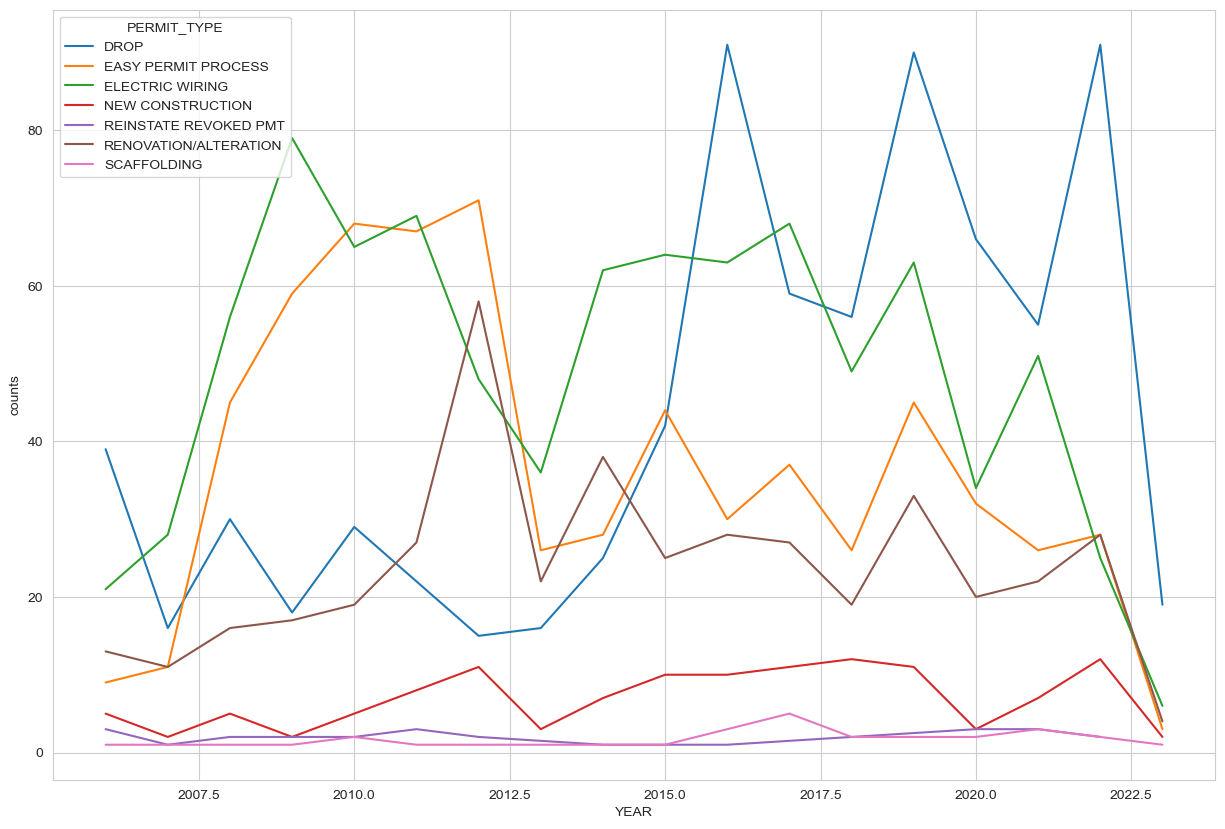

In [130]:
sns.set_style('whitegrid')

test=permits_wip_5[permits_wip_5.CENSUS_TRACT==842300].groupby(['PERMIT_TYPE','YEAR']).size().reset_index().rename(columns={0:'counts'})

test['permit_type_encoded'] = test['PERMIT_TYPE'].astype('category').cat.codes

fig, ax = plt.subplots(1,1, figsize=(15,10))

plt.subplot(1,1,1)
sns.lineplot(data=test,x='YEAR',y='counts',hue='PERMIT_TYPE')
plt.show()

Text(0.5, 1.0, 'Yearly number of review types for census tract 842300')

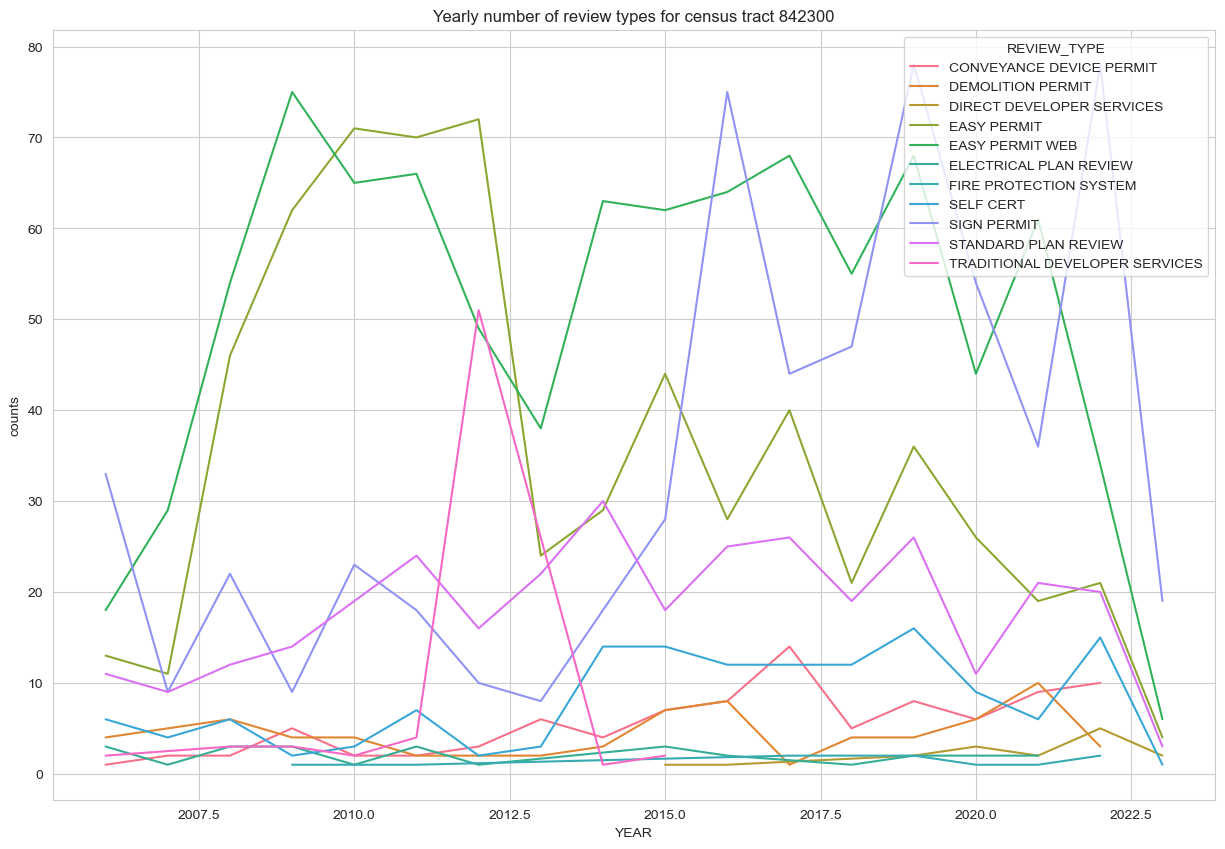

In [131]:
sns.set_style('whitegrid')

test=permits_wip_5[permits_wip_5.CENSUS_TRACT==842300].groupby(['REVIEW_TYPE','YEAR']).size().reset_index().rename(columns={0:'counts'})

test['permit_type_encoded'] = test['REVIEW_TYPE'].astype('category').cat.codes

fig, ax = plt.subplots(1,1, figsize=(15,10))

plt.subplot(1,1,1)
sns.lineplot(data=test,x='YEAR',y='counts',hue='REVIEW_TYPE')
plt.title('Yearly number of review types for census tract 842300')

## WORK DESCRIPTION NLP

* **`task-------`** These are absolute counts, should also consider the percentage counts (what percentage of all applications were of these type)

**`---nlp analysis---`**

In [132]:
description_series=permits_wip_5['WORK_DESCRIPTION']

description_series

0         INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...
1         new construction, erect 3 story slab on grade ...
2                                    north elevation 386431
3         Interior alteration of existing partial 34th f...
4         Interior alterations to the retail space on th...
                                ...                        
730506    SOLAR PANEL PERMIT.  ERECT A PHOTOVOLTAIC ARRA...
730507    FENCES: 165FT 0IN X 6FT 0IN: QTY 1 (not to be ...
730508    TECH WILL PULL 100 CAT-6 CABLES, TERMINATE, AN...
730509    REVISION TO PERMIT NO 100988130 TO CHANGE ELEC...
730510                                       REPAIR SERVICE
Name: WORK_DESCRIPTION, Length: 730511, dtype: object

In [133]:
import string

# import the nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44742\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
#define tokenizer
STOP_WORDS = stopwords.words('english')
STOP_WORDS.append('per')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listof_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in STOP_WORDS) & (len(word)>2) & (not bool(re.search('\d', word))):
            stemmer = PorterStemmer()
            stemmed_word = stemmer.stem(word)
            listof_words.append(stemmed_word)
            #listof_words.append(word)
        else:
            continue

    return listof_words

* Initial test is to apply `topic modelling` on **all of the descriptions**

`Cell below takes 7 min to run`

In [148]:
from sklearn.decomposition import LatentDirichletAllocation

'''#0.05 --> 5% of the documents
bagofwords = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.0001)
bagofwords.fit(description_series)
words_tranformed = bagofwords.transform(description_series)
print(words_tranformed.shape)'''

#joblib.dump(words_tranformed, '../data/interim/words_tranformed_test_1.pkl')
#joblib.dump(bagofwords, '../data/interim/words_tranformed_test_1_vector.pkl')

['../data/interim/words_tranformed_test_1_vector.pkl']

In [149]:
words_tranformed=joblib.load('../data/interim/words_tranformed_test_1.pkl')
bagofwords=joblib.load('../data/interim/words_tranformed_test_1_vector.pkl')

* Determine 10 distinct topics by running an LDA model

`Cell below takes 30 min to run`

In [152]:
'''# fit the LDA topic model
lda = LatentDirichletAllocation(n_components=10, max_iter=30,random_state=1,verbose=1)

lda.fit(words_tranformed)'''

#joblib.dump(lda, '../data/interim/fitted_lda.pkl')

['../data/interim/fitted_lda.pkl']

In [153]:
lda=joblib.load('../data/interim/fitted_lda.pkl')

* Print the topics

In [154]:
# for each topic, print the the top 10 most representative words
words = bagofwords.get_feature_names()

for i, topic in enumerate(lda.components_):
    topic_words = " ".join([words[j] for j in topic.argsort()[: -10: -1]])
    print(f"Topic #{i} words: {topic_words}")

Topic #0 words: instal violat cabl data electr timer correct switch air
Topic #1 words: low voltag alarm burglar instal system hot heater work
Topic #2 words: interior exist plan floor alter build space new offic
Topic #3 words: chang contractor permit wreck revis remov stori electr frame
Topic #4 words: work replac repair tuckpoint structur roof drywal exist plumb
Topic #5 words: mainten monthli sign elev electr illumin gener face build
Topic #6 words: porch wood rear open replac exist plan stair front
Topic #7 words: qti famili fenc erect singl roof garag resid new
Topic #8 words: garag elev passeng pursuant submit scope work hydraul instal
Topic #9 words: servic amp meter instal new light circuit upgrad outlet


In [139]:
topic_scores=lda.transform(words_tranformed)

planning_topics = topic_scores.argmax(axis=1)

permits_wip_5['New_Topics']=planning_topics

In [140]:
permits_wip_5['New_Topics']=permits_wip_5['New_Topics'].replace({0:'electrical',1:'alarm',2:'interior',3:'wrecking',4:'repair',5:'maintenance',6:'porch',7:'fence',8:'garage',9:'electricity upgrade'})

***
## EXPORT CLEANED DATAFRAME

In [142]:
permits_wip_5.to_csv('../data/clean/permits_cleaned.csv')